<h1><center>Telecom Plan Insights</center></h1>
<center><h2> Predicting customers likely to purchase new plan</h2> </center>

#### Importing Libraries

In [83]:
import pandas as pd # Library to read, write, explore and clean data
import numpy as np # Library to create and operate on arrays
import matplotlib.pyplot as plt # Library to plot visualizations
import seaborn as sns # Library to visualize

from sklearn import svm # Classification and regression library
from sklearn.model_selection import train_test_split # Splitting datasets into training and testing sets
from sklearn.linear_model import LogisticRegression # Classification algorithm
from sklearn.preprocessing import StandardScaler # Used for standardizing features
from sklearn.metrics import roc_auc_score, auc, roc_curve # Used for evaluating the ROC curves AUC scores in the context of a binary classification 
from sklearn import metrics # Provides various functions for evaluating the performance of machine learning models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay # Used for evaluating and analyzing the performance of a classification model

from imblearn.over_sampling import RandomOverSampler # Addresses class imbalance by oversampling the minority class
from imblearn.under_sampling import RandomUnderSampler # Addresses class imbalance by undersampling the majority class
from imblearn.over_sampling import SMOTE # Addresses class imbalance by creating synthetic data of the minority class
from collections import Counter # Used for counting occurrences of elements in a collection


### Data Cleaning

In [84]:
data = pd.read_excel('Telecom.xlsx',sheet_name='Telecom') # Reading the data
print(data.shape) # Printing the shape (rows, columns) of the data

(4888, 20)


In [85]:
data.columns     # prints column names

Index(['CustomerID', 'PlanTaken', 'Age', 'TypeofContact', 'CityTier',
       'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersons',
       'NumberOfFollowups', 'PlanPitched', 'PreferredServiceStar',
       'MaritalStatus', 'NumberOfUpgrades', 'iPhone', 'PitchSatisfactionScore',
       'PhoneContract', 'NumberOfChildren', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [86]:
data.info() # Checking the datatypes of all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              4888 non-null   int64  
 1   PlanTaken               4888 non-null   int64  
 2   Age                     4662 non-null   float64
 3   TypeofContact           4863 non-null   object 
 4   CityTier                4888 non-null   int64  
 5   DurationOfPitch         4637 non-null   float64
 6   Occupation              4888 non-null   object 
 7   Gender                  4888 non-null   object 
 8   NumberOfPersons         4888 non-null   int64  
 9   NumberOfFollowups       4843 non-null   float64
 10  PlanPitched             4888 non-null   object 
 11  PreferredServiceStar    4862 non-null   float64
 12  MaritalStatus           4888 non-null   object 
 13  NumberOfUpgrades        4748 non-null   float64
 14  iPhone                  4888 non-null   

In [87]:
# Changing the data types as some features are ordinal and nominal data with numeric values
data['CityTier'] = data['CityTier'].astype('object')
data['PreferredServiceStar'] = data['PreferredServiceStar'].astype('object')
data['iPhone']  = data['iPhone'].astype('object')
data['NumberOfChildren'] =data['NumberOfChildren'].astype('object')
data['PitchSatisfactionScore'] = data['PitchSatisfactionScore'].astype('object')
data['PhoneContract'] = data['PhoneContract'].astype('object')

In [88]:
data.head()

,CustomerID,PlanTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersons,NumberOfFollowups,PlanPitched,PreferredServiceStar,MaritalStatus,NumberOfUpgrades,iPhone,PitchSatisfactionScore,PhoneContract,NumberOfChildren,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [89]:
data.Gender.value_counts() #Checking the unique values in Gender column

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [90]:
data.Gender.replace({'Fe Male':'Female'},inplace = True) # Replacing the Fe Male values with Female
data.Gender.value_counts()

Gender
Male      2916
Female    1972
Name: count, dtype: int64

##### Missing Values Analysis

In [91]:
data.isnull().sum()     # number of null values in each column

CustomerID                  0
PlanTaken                   0
Age                       226
TypeofContact              25
CityTier                    0
DurationOfPitch           251
Occupation                  0
Gender                      0
NumberOfPersons             0
NumberOfFollowups          45
PlanPitched                 0
PreferredServiceStar       26
MaritalStatus               0
NumberOfUpgrades          140
iPhone                      0
PitchSatisfactionScore      0
PhoneContract               0
NumberOfChildren           66
Designation                 0
MonthlyIncome             233
dtype: int64

There are a lot of features having missing values.

In [92]:
data.describe()        # descriptive statistics of all numerical features in the data

,CustomerID,PlanTaken,Age,DurationOfPitch,NumberOfPersons,NumberOfFollowups,NumberOfUpgrades,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4637.000000,4888.000000,4843.000000,4748.000000,4655.000000
mean,202443.500000,0.188216,37.622265,15.490835,2.905074,3.708445,3.236521,23619.853491
std,1411.188388,0.390925,9.316387,8.519643,0.724891,1.002509,1.849019,5380.698361
min,200000.000000,0.000000,18.000000,5.000000,1.000000,1.000000,1.000000,1000.000000
25%,201221.750000,0.000000,31.000000,9.000000,2.000000,3.000000,2.000000,20346.000000
50%,202443.500000,0.000000,36.000000,13.000000,3.000000,4.000000,3.000000,22347.000000
75%,203665.250000,0.000000,44.000000,20.000000,3.000000,4.000000,4.000000,25571.000000
max,204887.000000,1.000000,61.000000,127.000000,5.000000,6.000000,22.000000,98678.000000


#### Handling Numerical Features

In [93]:
num_columns = data.select_dtypes(exclude='object').columns.tolist()
len(num_columns)

8

In the below code, we will be visualizing the distribution of the numerical features in the dataset to observe for skewness. Features having skewness will have the missing values imputed with the median else the mean

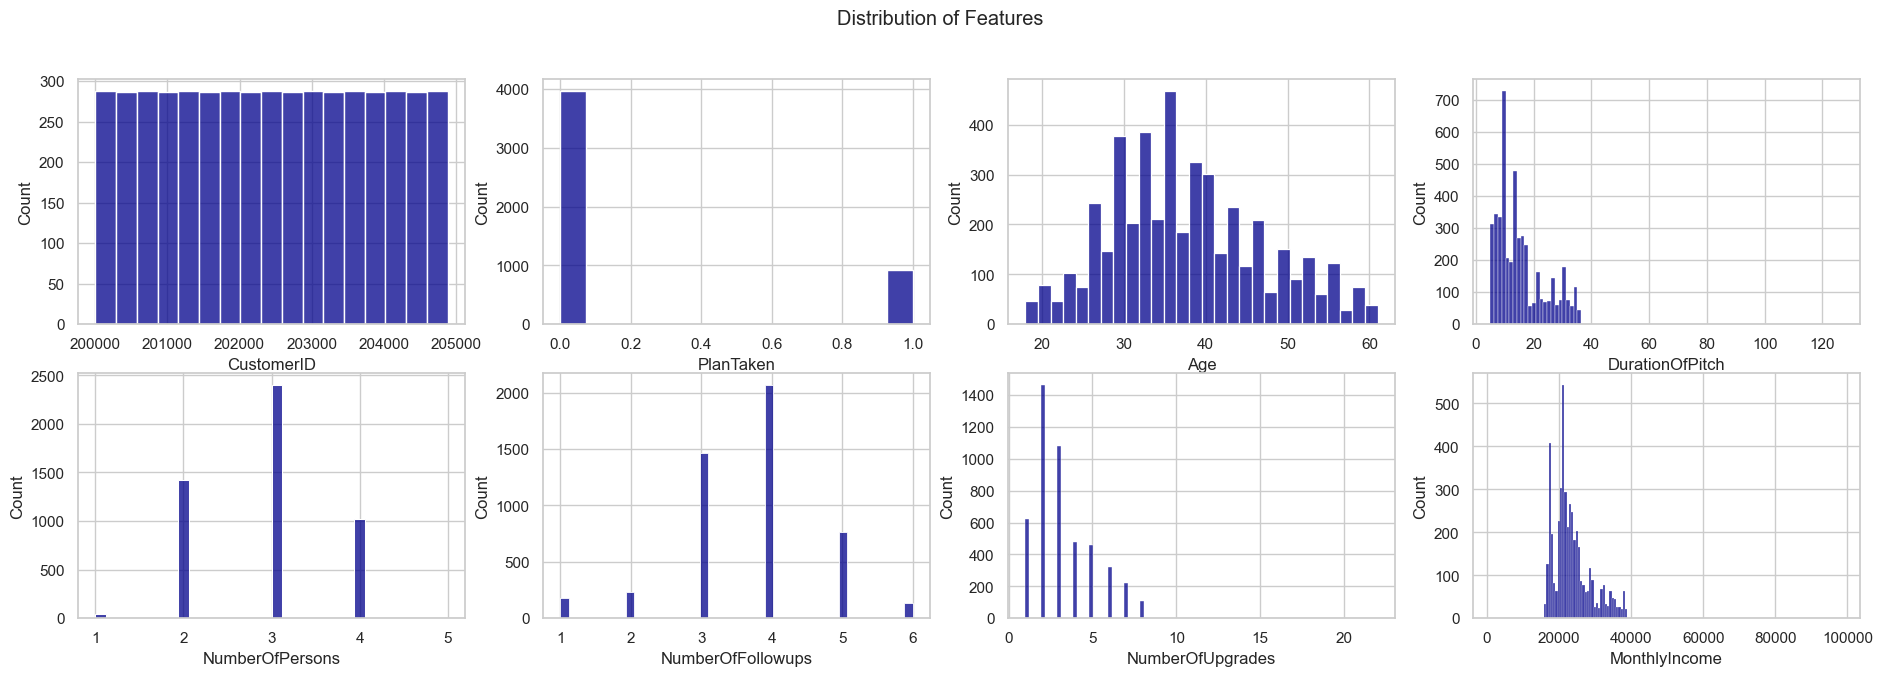

CustomerID           0.000000
PlanTaken            1.595763
Age                  0.382989
DurationOfPitch      1.752037
NumberOfPersons      0.029817
NumberOfFollowups   -0.372719
NumberOfUpgrades     1.453884
MonthlyIncome        1.949160
dtype: float64

In [94]:
fig,axs = plt.subplots(2,4,figsize=(23,7))
i = 1
j = 1
fig.suptitle("Distribution of Features")
for col in num_columns:
    sns.histplot(data[col],ax=axs[i-1][j-1],fill=True,color="darkblue") # density plot of the Age feature to visualize the slight skewness present in the data
    if (j%4 == 0): i += 1
    if j != 4: j+=1
    else: j = 1

plt.show()
data[num_columns].skew()

- The first feature can be ignored as it is ID (primary key)
- The second feature is the target variable which is boolean. It also doesn't have any missing values.
- Age feature had low skewness, so any null values present an be filled with either mean or median
- Duration of Pitch has a high positive skewness, so missing values if present will be filled up using median
- NumberofPersons feature has no null values, so it can be ignored in this case. It is also not skewed.

- NumberofFOllowups feature has low skewness, so missing values can be filled using median
- NumberOfUpgrades and MonthlyIncome are positively skewed. Filling up missing values with medain

In [95]:
# Handling the missing values in the data for numerical columns
data['Age'].fillna(data['Age'].median(),inplace = True)
data['DurationOfPitch'].fillna(data['DurationOfPitch'].median(),inplace = True)
data['NumberOfFollowups'].fillna(data['NumberOfFollowups'].median(),inplace = True)
data['NumberOfUpgrades'].fillna(data['NumberOfUpgrades'].median(),inplace = True)
data['MonthlyIncome'].fillna(data['MonthlyIncome'].median(),inplace = True)

In [96]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
len(cat_columns)

12

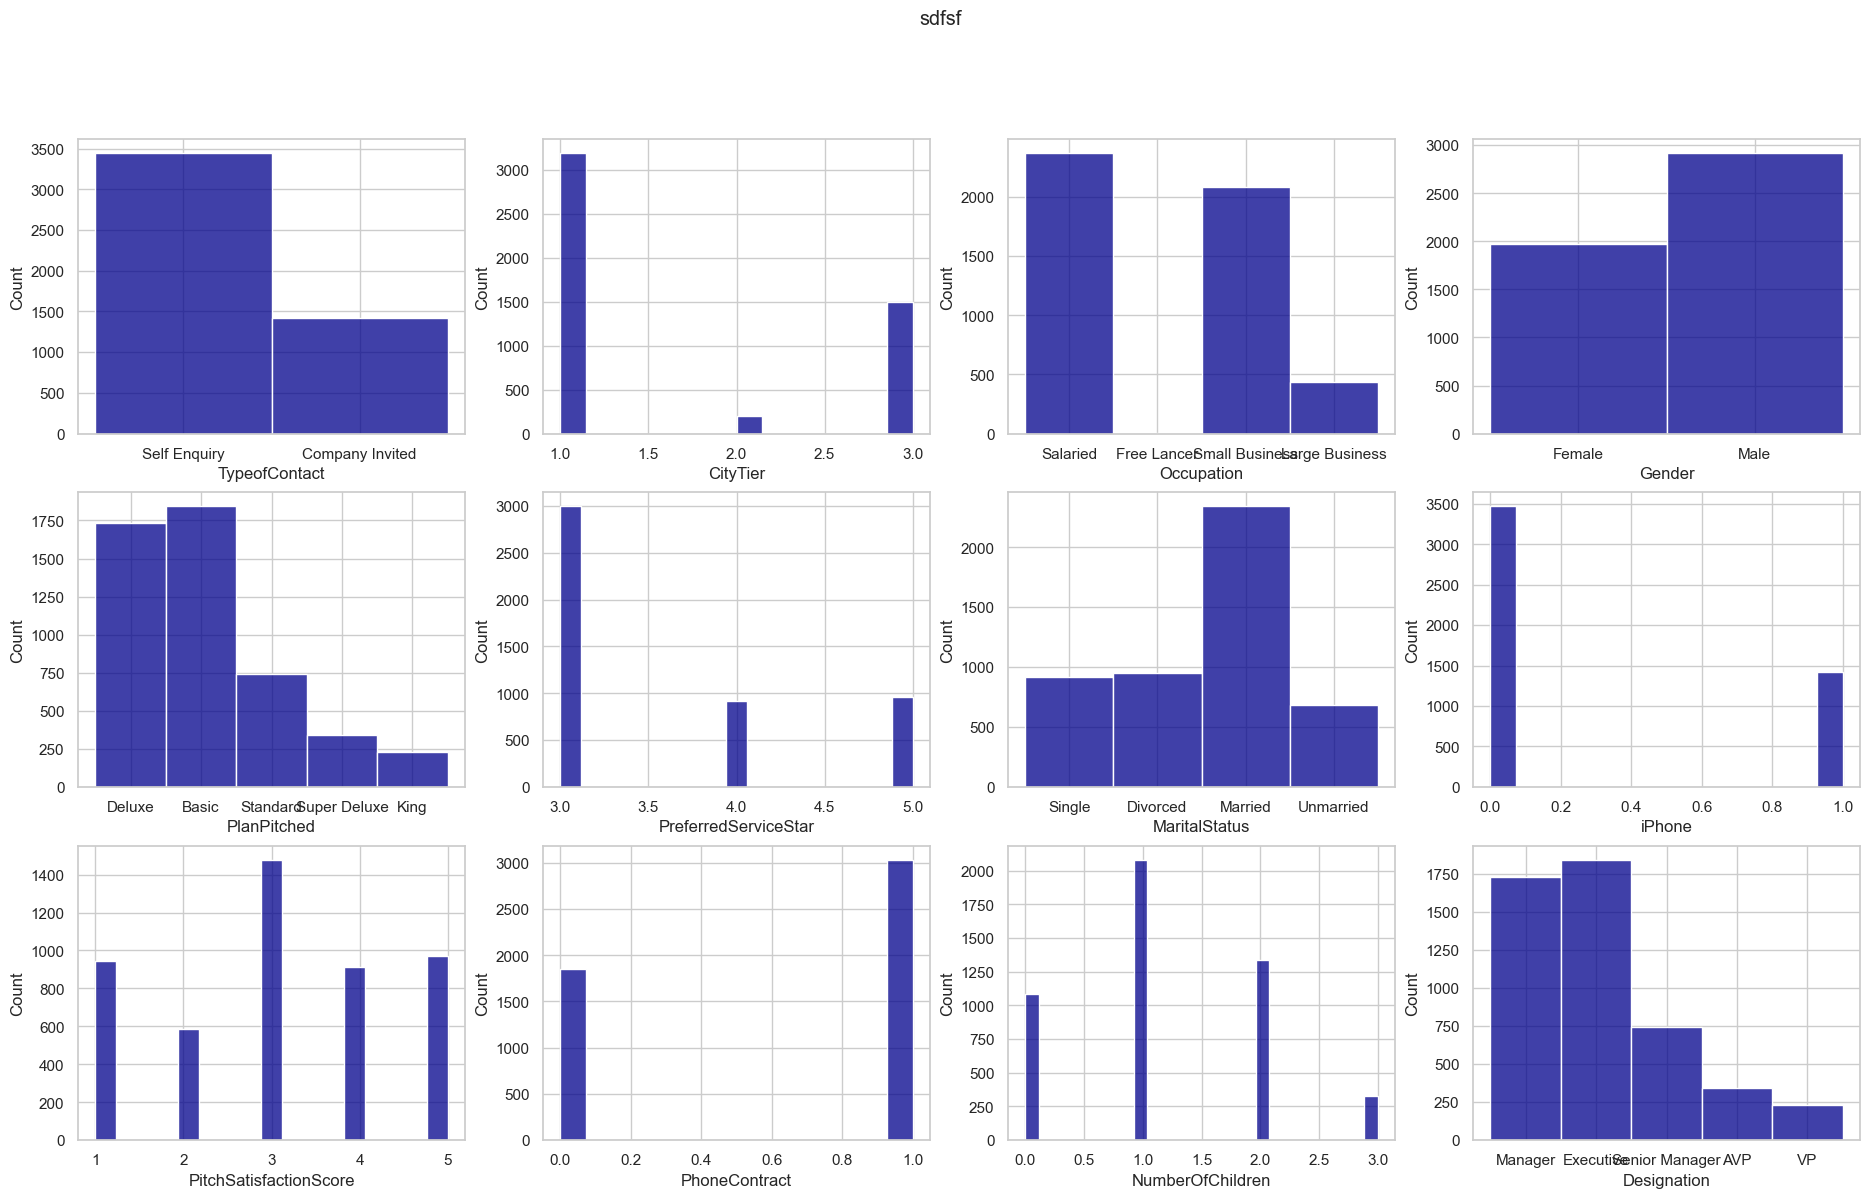

In [97]:
fig,axs = plt.subplots(3,4,figsize=(23,13))
i = 1
j = 1
fig.suptitle("sdfsf")
for col in cat_columns:
    sns.histplot(data[col],ax=axs[i-1][j-1],fill=True,color="darkblue") # density plot of the Age feature to visualize the slight skewness present in the data
    if (j%4 == 0): i += 1
    if j != 4: j+=1
    else: j = 1

plt.show()

In [98]:
data.describe(include='object')

,TypeofContact,CityTier,Occupation,Gender,PlanPitched,PreferredServiceStar,MaritalStatus,iPhone,PitchSatisfactionScore,PhoneContract,NumberOfChildren,Designation
count,4863,4888,4888,4888,4888,4862.0,4888,4888,4888,4888,4822.0,4888
unique,2,3,4,2,5,3.0,4,2,5,2,4.0,5
top,Self Enquiry,1,Salaried,Male,Basic,3.0,Married,0,3,1,1.0,Executive
freq,3444,3190,2368,2916,1842,2993.0,2340,3466,1478,3032,2080.0,1842


- The rest of the null features are: TypeofContact, PreferredServiceStar and NumberofChildren. So we will only focus on these. 
- Since these are all categorical features, we will replace the null values with the mode.

In [99]:
data['TypeofContact'].fillna(data['TypeofContact'].mode()[0],inplace = True)
data['PreferredServiceStar'].fillna(data['PreferredServiceStar'].mode()[0],inplace = True)
# data['PreferredServiceStar'] =data['PreferredServiceStar'].astype('object')

data['NumberOfChildren'].fillna(data['NumberOfChildren'].mode()[0],inplace = True)
# data['NumberOfChildren'] =data['NumberOfChildren'].astype('object')


In [100]:
data.isnull().sum()# no more missing data points

CustomerID                0
PlanTaken                 0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersons           0
NumberOfFollowups         0
PlanPitched               0
PreferredServiceStar      0
MaritalStatus             0
NumberOfUpgrades          0
iPhone                    0
PitchSatisfactionScore    0
PhoneContract             0
NumberOfChildren          0
Designation               0
MonthlyIncome             0
dtype: int64

Hence, the null values have been imputed.

### Exploratory Data Analysis and Data-Preprocessing

##### Handling the Outliers

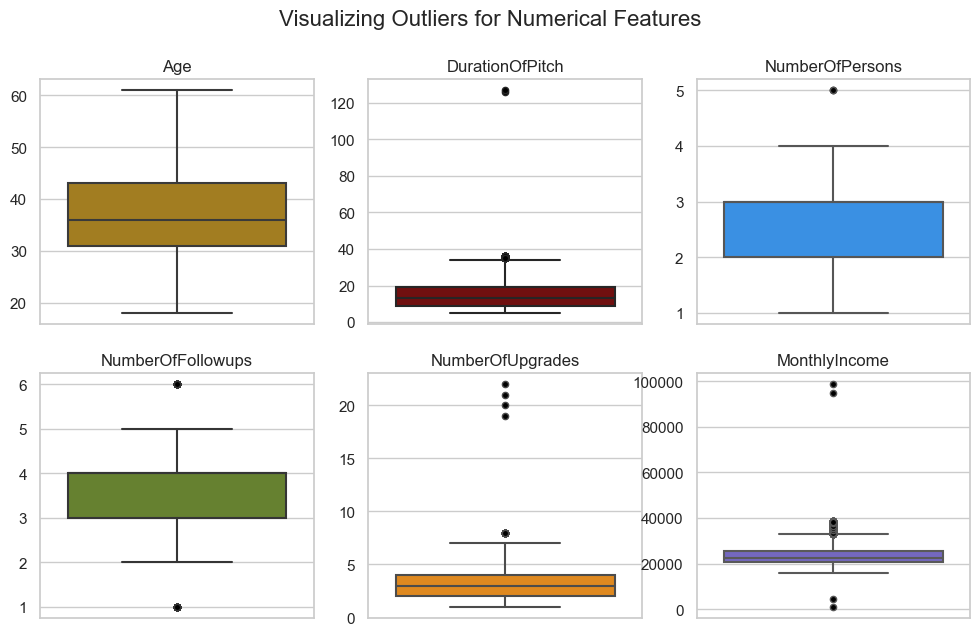

In [101]:
fig, axs = plt.subplots(2,3,figsize=(12,7))
clmns = ['Age', 'DurationOfPitch', 'NumberOfPersons', 'NumberOfFollowups','NumberOfUpgrades','MonthlyIncome']      # selecting columns
colors = ['darkgoldenrod','maroon','dodgerblue','olivedrab','darkorange','slateblue']         # color of each plot

i=0
while i!=len(clmns):        # iterating over the columns count
    try:
        for row in range(2):     # each row of the subplot
            for col in range(3): # each column of the subplot

                # boxplot for each numerical feature
                sns.boxplot(y = clmns[i] ,data = data,ax = axs[row][col] ,color=colors[i],flierprops=dict(markerfacecolor='black', marker='.', markersize=9))
                axs[row][col].set_title(clmns[i])    # setting the title name as the column name
                axs[row][col].set(ylabel = None)      # setting the y lable to None. Shared axis
                i+=1
    except:
        continue

# Set a title for the entire box plot
plt.suptitle('Visualizing Outliers for Numerical Features', fontsize=16)
plt.show()

In [102]:
def replace_outliers(col):         # Replacing outliers with the lower and upper limit
    IQR = col.quantile(0.75) - col.quantile(0.25)         # IQR calculation
    ll = col.quantile(0.25) - 1.5*IQR            # lower limit
    ul = col.quantile(0.75) +1.5*IQR             # upper limit
    col = col.apply(lambda row:ul if row > ul else ll if row < ll else row)            # apply changes to each row of the data
    return col

numlist = data.select_dtypes(exclude='object').columns.tolist()[2:]        
for item in numlist:
    data[item] = replace_outliers(data[item])

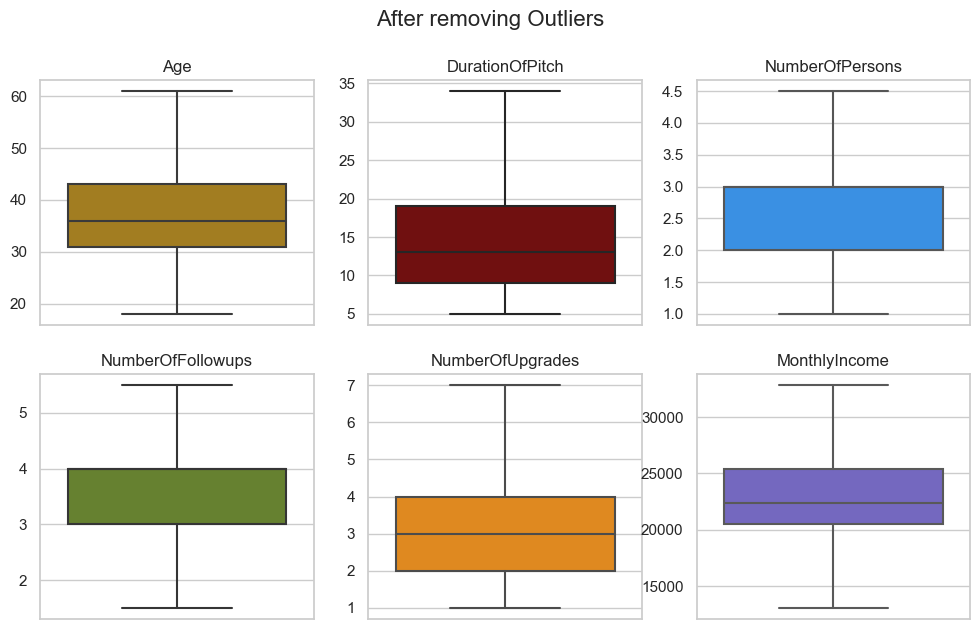

In [103]:
## Visualizing the boxplots for the changes
fig, axs = plt.subplots(2,3,figsize=(12,7))
clmns = ['Age', 'DurationOfPitch', 'NumberOfPersons', 'NumberOfFollowups','NumberOfUpgrades','MonthlyIncome']
colors = ['darkgoldenrod','maroon','dodgerblue','olivedrab','darkorange','slateblue']

i=0
while i!=len(clmns):
    try:
        for row in range(2):
            for col in range(3):
                sns.boxplot(y = clmns[i] ,data = data,ax = axs[row][col] ,color=colors[i],flierprops=dict(markerfacecolor='black', marker='.', markersize=9))
                axs[row][col].set_title(clmns[i])
                axs[row][col].set(ylabel = None)
                i+=1
    except:
        continue

# Set a title for the entire box plot
plt.suptitle('After removing Outliers', fontsize=16)
plt.show()

Hence, all Outliers have been removed. 

In [104]:
data.drop('CustomerID',axis=1,inplace = True)       # dropping customer ID as there is no relevant analysis that can be inferred from it

#### Exploratory Data Analysis

In [105]:
numeric_data = data.select_dtypes(include='number')          # numerical data features
numeric_data

,PlanTaken,Age,DurationOfPitch,NumberOfPersons,NumberOfFollowups,PreferredServiceStar,NumberOfUpgrades,NumberOfChildren,MonthlyIncome
0,1,41.0,6.0,3.0,3.0,3.0,1.0,0.0,20993.0
1,0,49.0,14.0,3.0,4.0,4.0,2.0,2.0,20130.0
2,1,37.0,8.0,3.0,4.0,3.0,7.0,0.0,17090.0
3,0,33.0,9.0,2.0,3.0,3.0,2.0,1.0,17909.0
4,0,36.0,8.0,2.0,3.0,4.0,1.0,0.0,18468.0
...,...,...,...,...,...,...,...,...,...
4883,1,49.0,9.0,3.0,5.0,4.0,2.0,1.0,26576.0
4884,1,28.0,31.0,4.0,5.0,3.0,3.0,2.0,21212.0
4885,1,52.0,17.0,4.0,4.0,4.0,7.0,3.0,31820.0
4886,1,19.0,16.0,3.0,4.0,3.0,3.0,2.0,20289.0


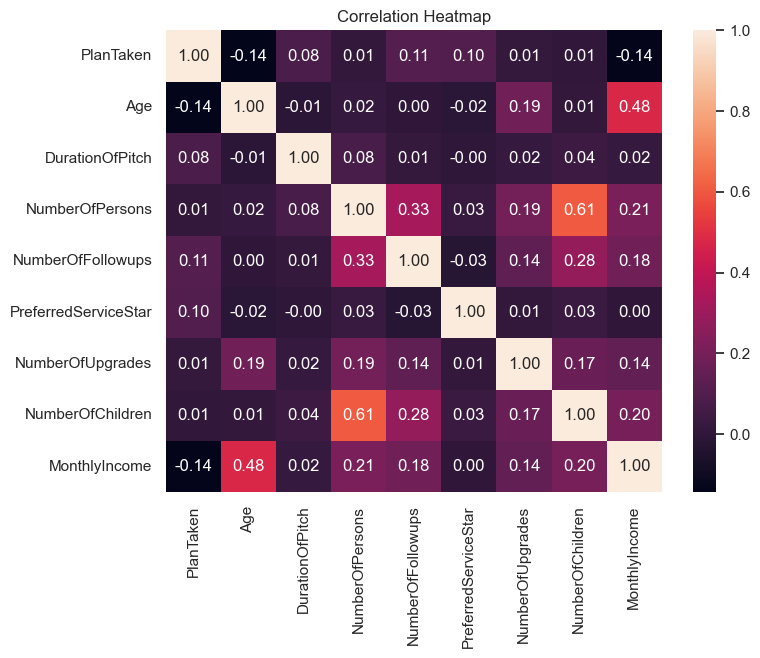

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f') # heatmap for the correlation values for the numerical features
plt.title('Correlation Heatmap')
plt.show()

We can see that there is multicollinearity between few columns. Features having correlation > 0.6 will be cosidered redundant for both features. Therefore, we will drop one of those columns at random. 

Not dropping either MonthlyIncome or Age since their correlation is 0.48. Which is considered to be only a moderate correlation.

Number of Children and Number of Persons have a strong correlation. One of these features will be dropped. Column having a lower correlation with the Target 'PlanTaken'  will be removed. As both features have some correlation, dropping either one

In [107]:
data.drop(['NumberOfChildren'],axis=1,inplace=True)
data.shape

(4888, 18)

##### Univariate Analysis

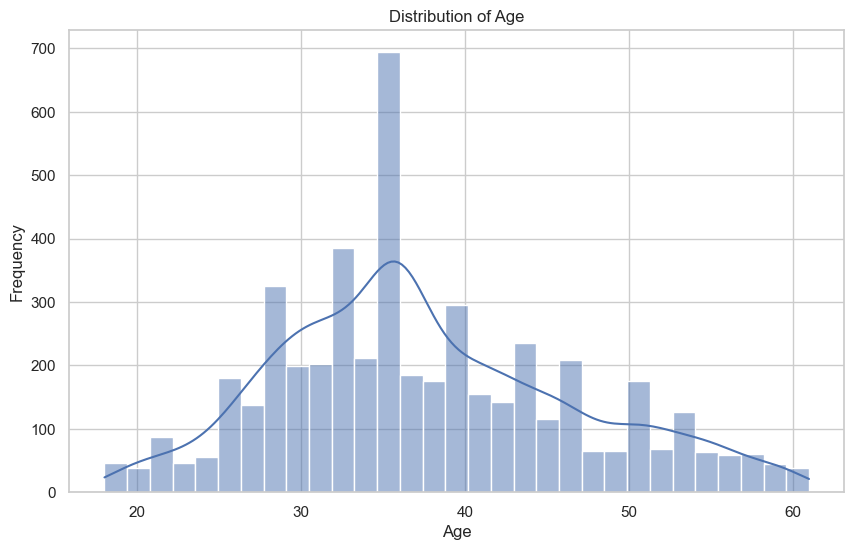

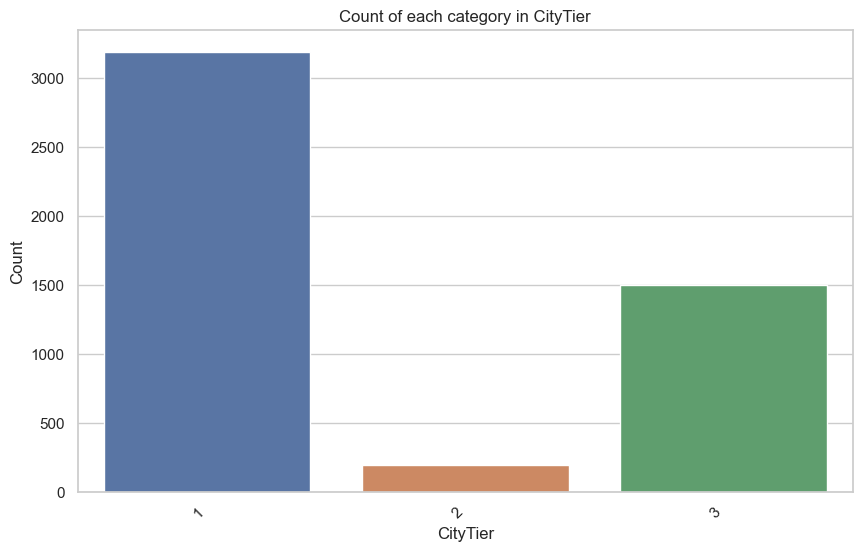

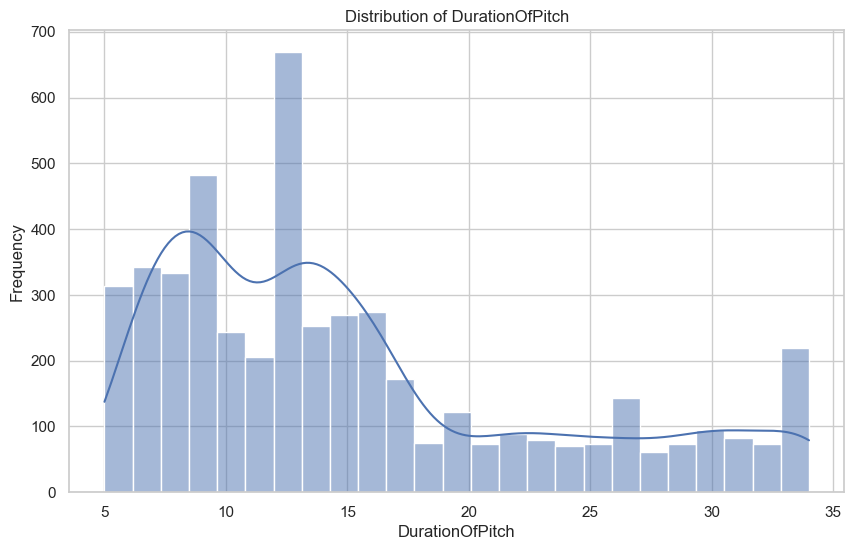

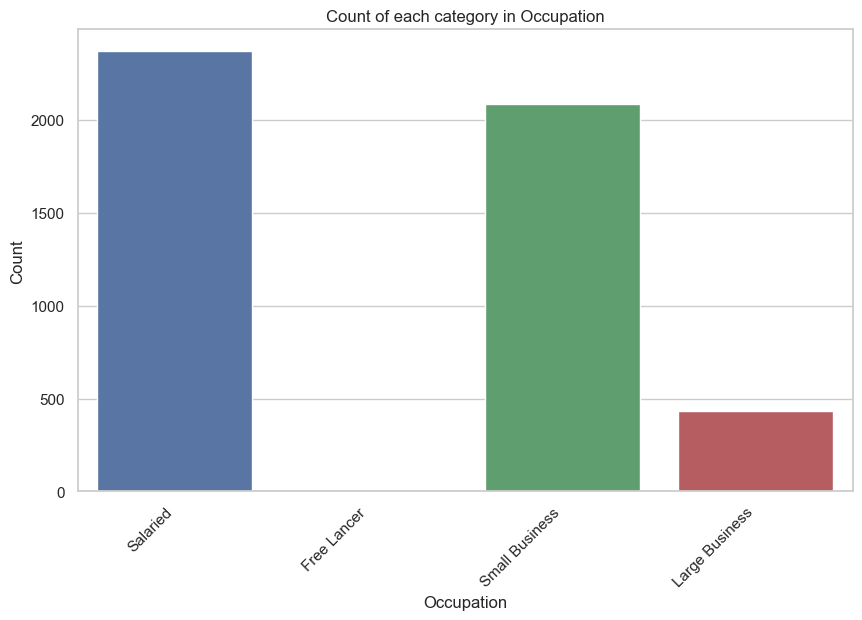

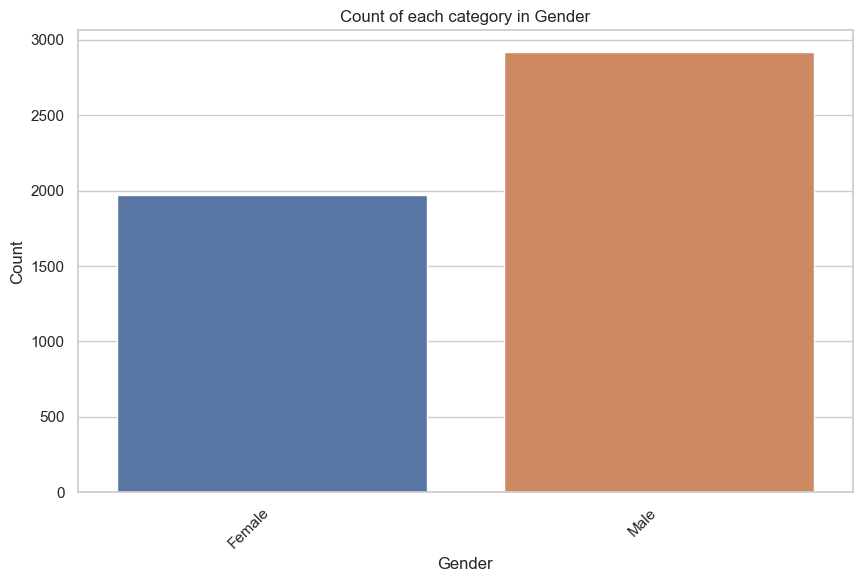

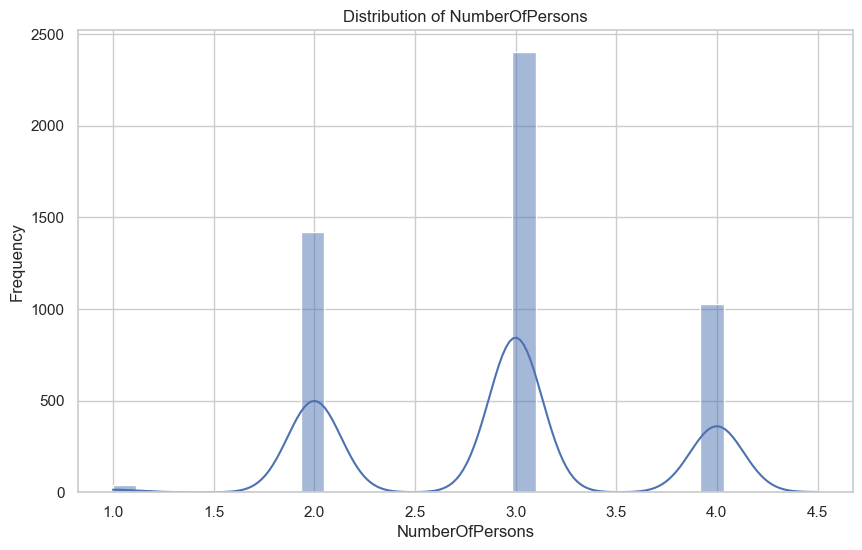

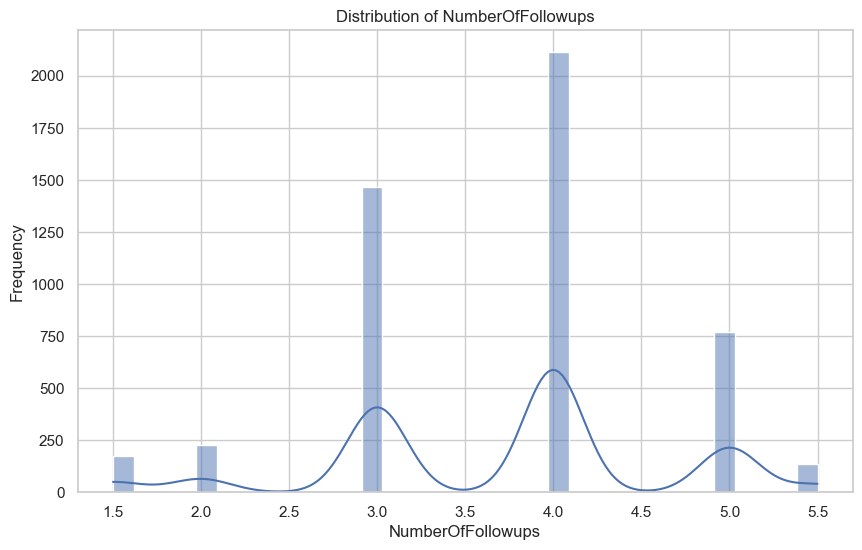

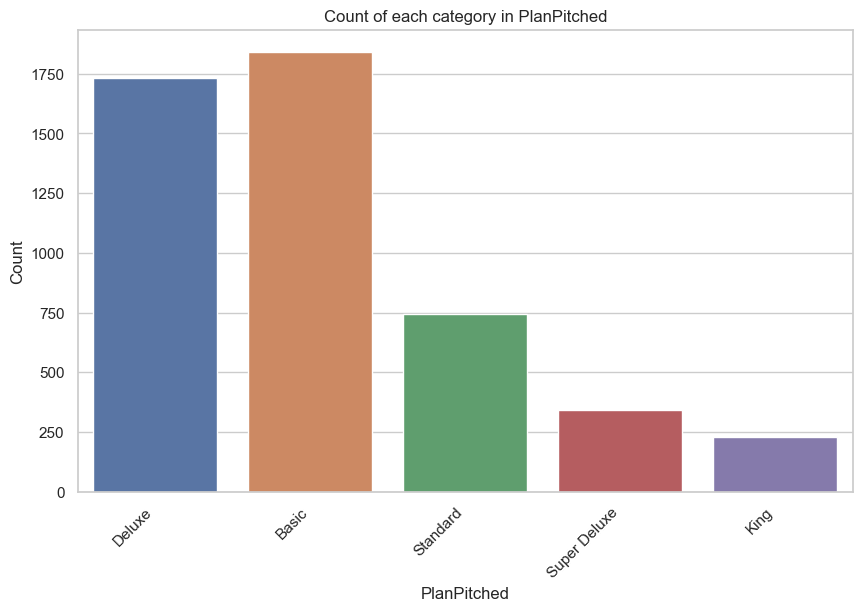

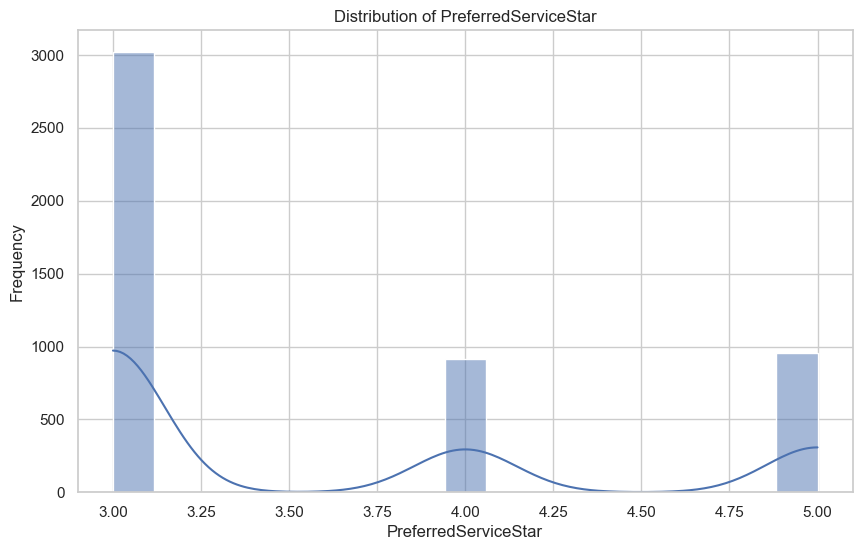

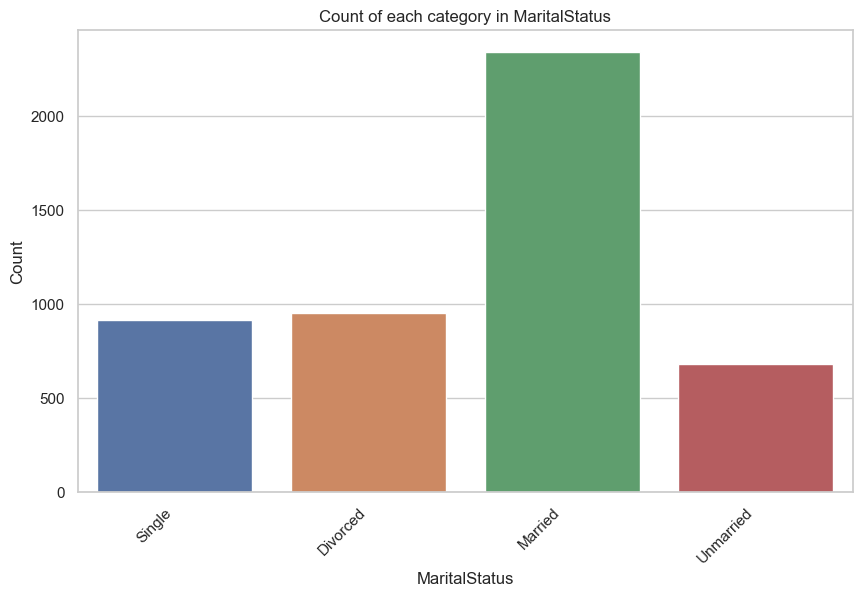

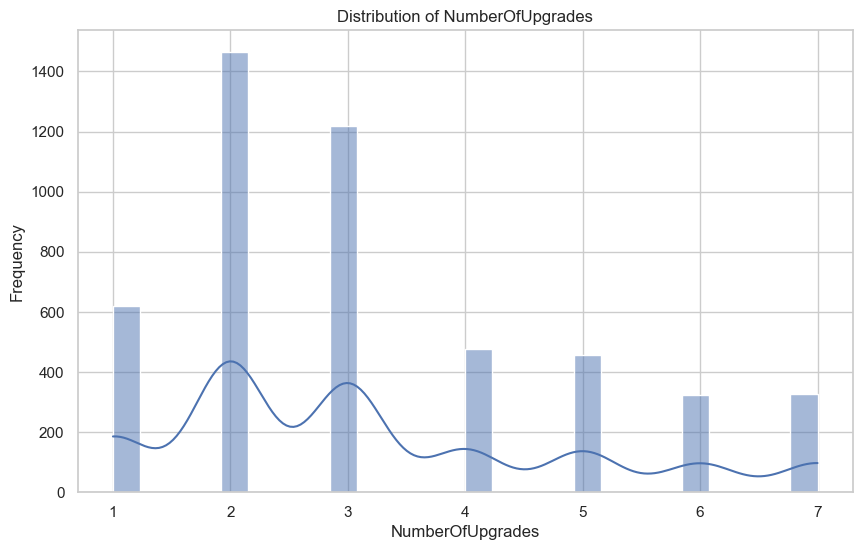

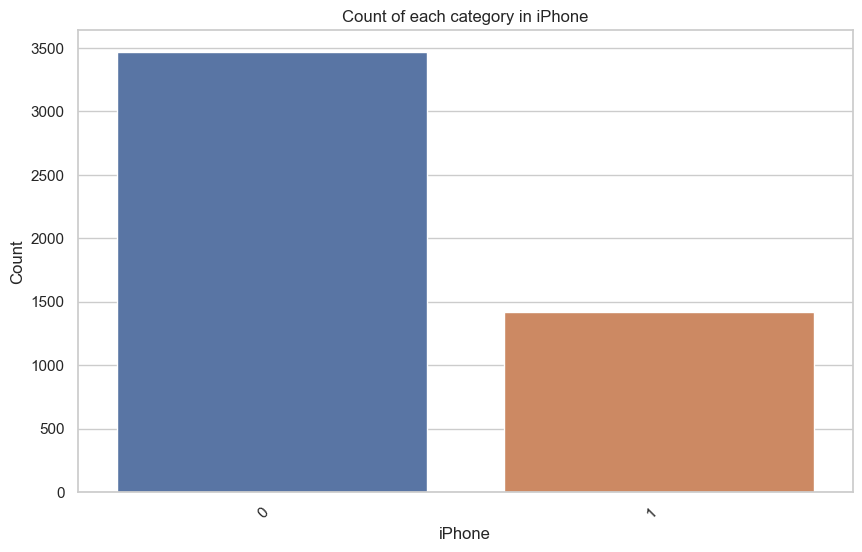

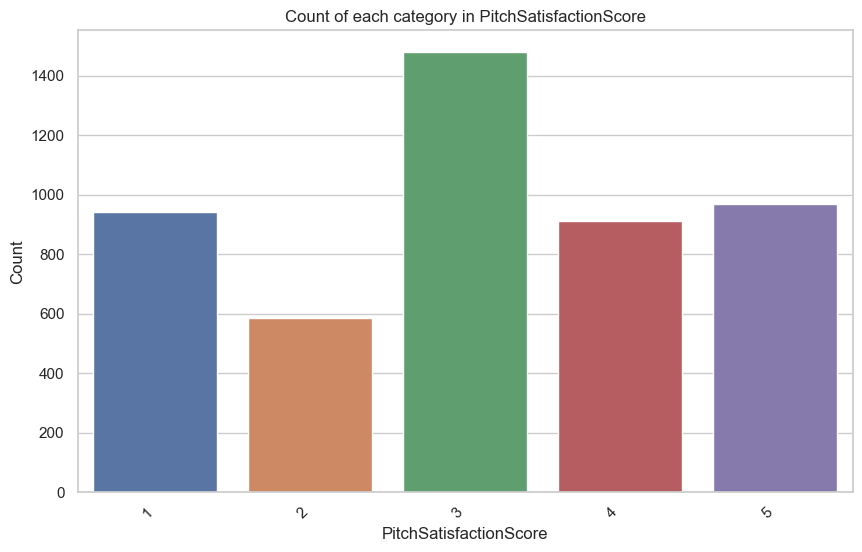

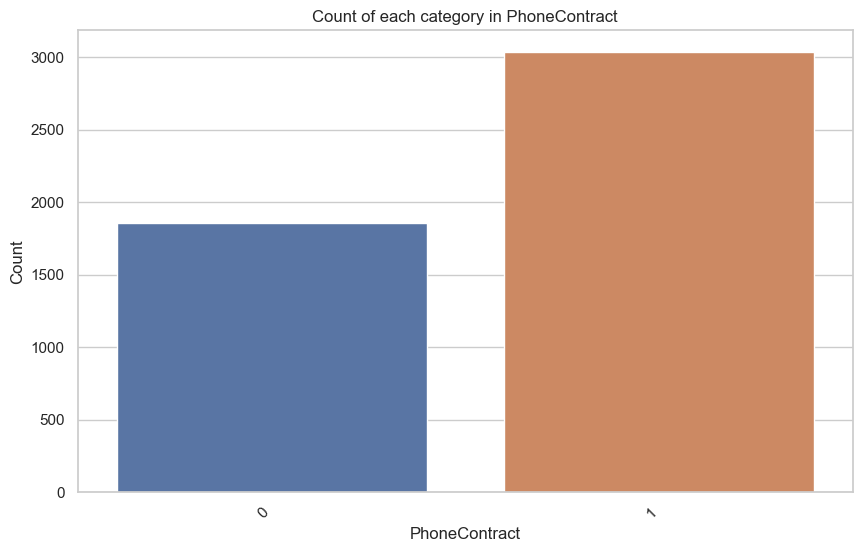

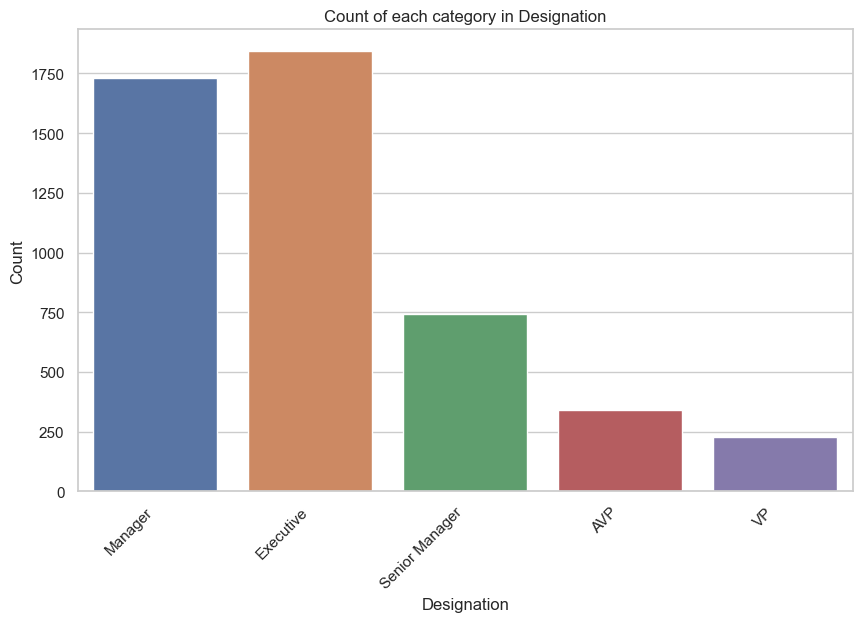

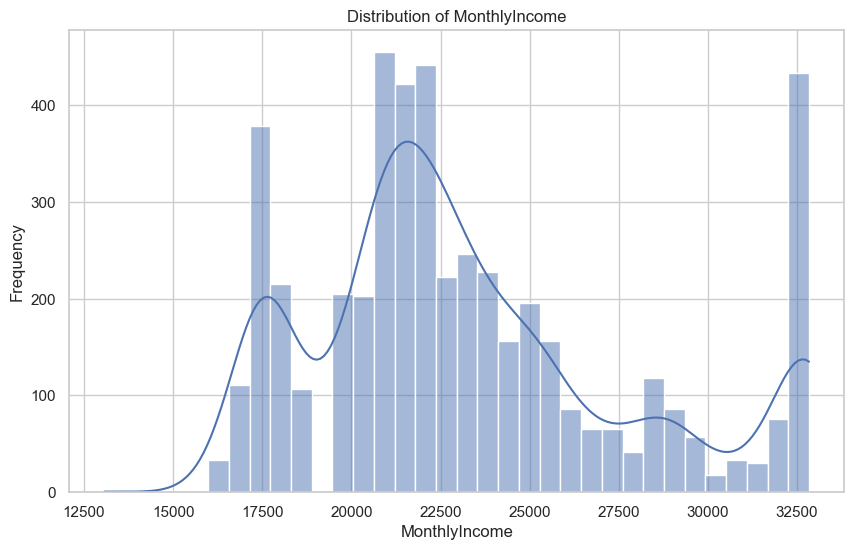

In [108]:
# Set the style for Seaborn plots
sns.set(style="whitegrid")

# choosing columns for univariate analysis
columns_for_analysis = [
    'Age',
    'CityTier',
    'DurationOfPitch',
    'Occupation',
    'Gender',
    'NumberOfPersons',
    'NumberOfFollowups',
    'PlanPitched',
    'PreferredServiceStar',
    'MaritalStatus',
    'NumberOfUpgrades',
    'iPhone',
    'PitchSatisfactionScore',
    'PhoneContract',
    #'NumberOfChildren',
    'Designation',
    'MonthlyIncome'
]

# Going through each column for univariate analysis
for column in columns_for_analysis:
    plt.figure(figsize=(10, 6))
    
    # Numeric columns
    if data[column].dtype in ['float64', 'int64']:
        sns.histplot(data[column], kde=True)         # histogram plot for each numerical feature
        plt.title(f'Distribution of {column}') # setting the title
        plt.xlabel(column) # x lable as column name
        plt.ylabel('Frequency') # y lable 
        plt.show()
    
    # Categorical columns
    else:
        sns.countplot(x=column, data=data)          # countplot for each categorical feature
        plt.title(f'Count of each category in {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.show()


- Average age of the customers are around 35 years
- Most customers are from Tier 1. This tells us the most customers come from affluent regions
- A majority of sales people have a pitch time of less than 15 minutes
- Most customers are either salaried or with small business
- There are more male customers than female customers

##### Bivariate Analysis with Target

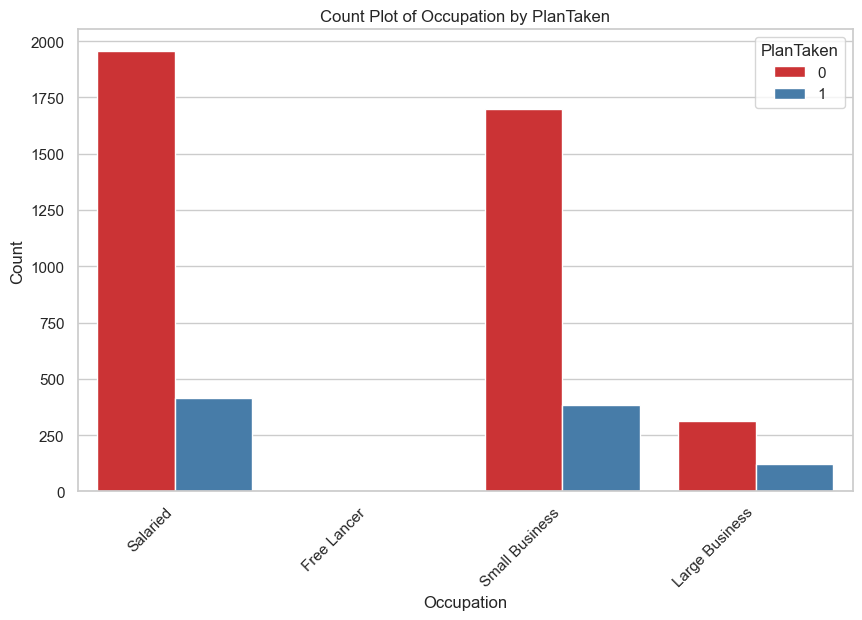

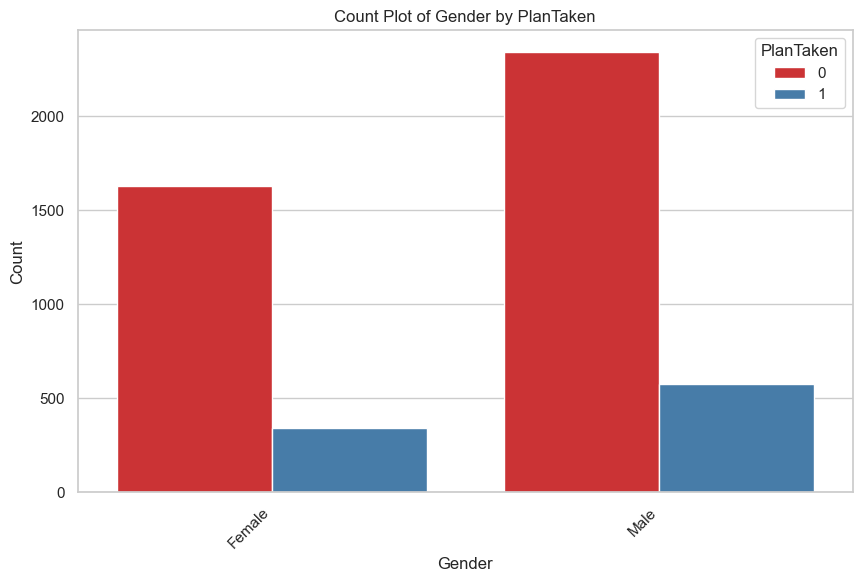

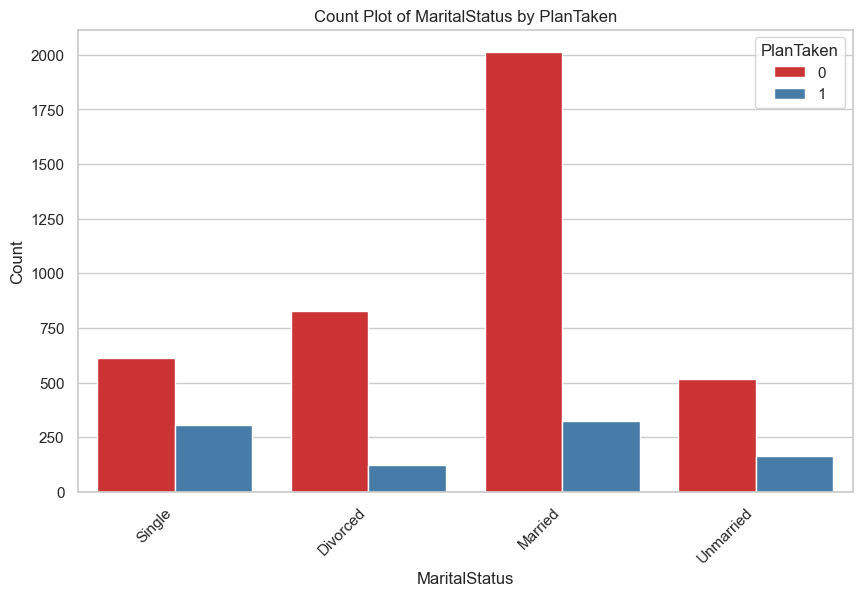

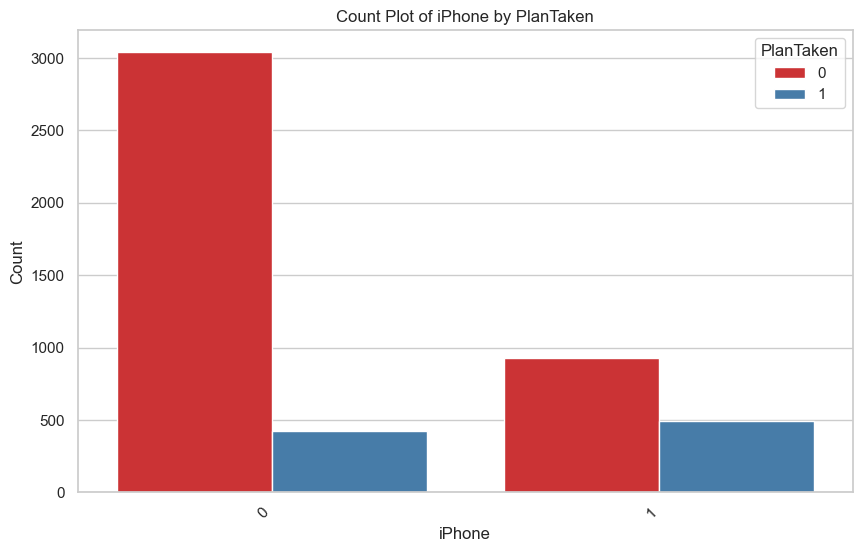

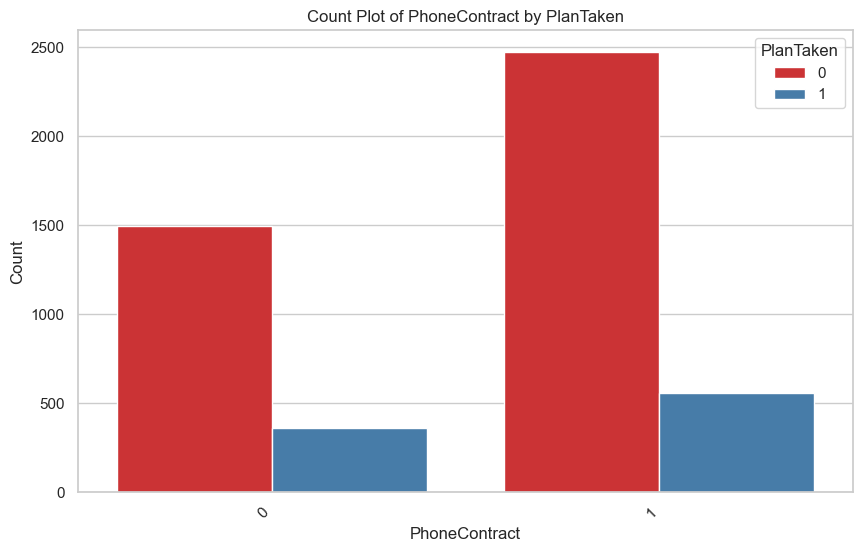

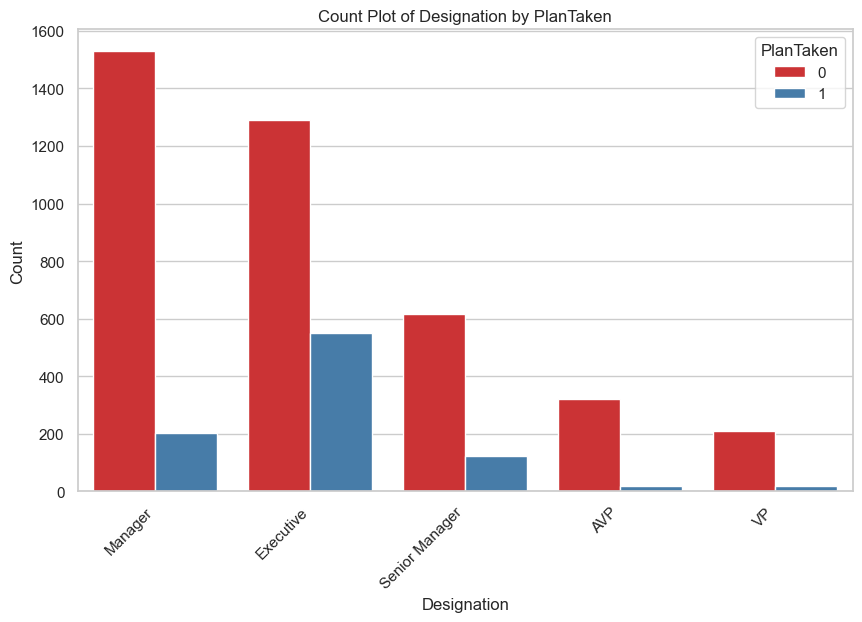

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Define columns for bivariate analysis
columns_for_bivariate_analysis = [
    'Age',
    'CityTier',
    'DurationOfPitch',
    'NumberOfPersons',
    'NumberOfFollowups',
    'PreferredServiceStar',
    'NumberOfUpgrades',
    'MonthlyIncome',
    'PitchSatisfactionScore'
]

# Count plots for categorical columns
categorical_columns = ['Occupation', 'Gender', 'MaritalStatus', 'iPhone', 'PhoneContract', 'Designation']
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='PlanTaken', data=data, palette='Set1')      # plotting the countplot
    plt.title(f'Count Plot of {column} by PlanTaken')         # title of the chart
    plt.xlabel(column)       # x axis label
    plt.ylabel('Count')           # y axis label
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()


- Ratio of Salaried Individuals taking a plan to not taking a plan is very low compared to large business. 
- Majority of the customers are males. 
- Ratio of Married individuals taking a plan to not taking a plan is very high compared to unmarried individuals. With a majority of customers being married.
- Majority of the customers who do not have an iPhone, did not take a plan.
- Most of the customers who took a plan are at an executive designation, however the most who did not are at the managerial positions. Meanwhile, the least amount of customers who either decided to take a plan or not were in the Vice President positions.

#### Feature Engineering

In [110]:
X = data.drop('PlanTaken', axis=1)     # independent features
y = data['PlanTaken']                  # target variable

X_enc = pd.get_dummies(X, columns=data.select_dtypes(include=object).columns.to_list(),dtype = 'int')        # Encoding all 

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)       # splitting data into 80:20 train test split

scaler = StandardScaler()             # initializing the scaling object
X_train_scaled = scaler.fit_transform(X_train)           # train data scaling
X_test_scaled = scaler.transform(X_test)              # test data scaling

#### Model Evaluation Function 

In [111]:
def model_evaluation(model,y_train, y_test,X_train_sc,X_test_sc): # Model evaluation function that outputs the train and test accuracy. 
                                                                             
    ### Model Accuracy - Train
    y_pred_train = model.predict(X_train_sc)
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Training Accuracy of this model:", accuracy)

    ### Model Accuracy - Test
    y_pred_test = model.predict(X_test_sc)
    accuracy = accuracy_score(y_test, y_pred_test)
    print("Testing Accuracy of this model:", accuracy)

    ### Confusion Matrix 
    conf_matrix = confusion_matrix(y_test, y_pred_test) # Confusion matrix of the predictions and the classification report of the same.
    print("\nConfusion Matrix:")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [1, 0])
    cm_display.plot()
    plt.show()

    ### Report of the model:
    classification_rep = classification_report(y_test, y_pred_test)
    print("\nClassification Report:")
    print(classification_rep)


#### AUC and ROC Curve Function 

In [112]:
def auc_roc_curve(model,X_test_sc,y_test_roc):          # Function to display the AUC and ROC curve for every model we created
    probabilities_1 = model.predict_proba(X_test_sc)[:, 1]              # Probabilities of each class attribute
    auc_model = metrics.roc_auc_score(y_test_roc, probabilities_1)      # Get the roc and auc score of the y value with the probabilities
    print(f'AUC ={auc_model}')

    fpr, tpr, thresholds1 = metrics.roc_curve(y_test_roc, probabilities_1) 
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

#### Logistic Regression

##### 1) Base Modelling

Training Accuracy of this model: 0.8521739130434782
Testing Accuracy of this model: 0.8384458077709611

Confusion Matrix:


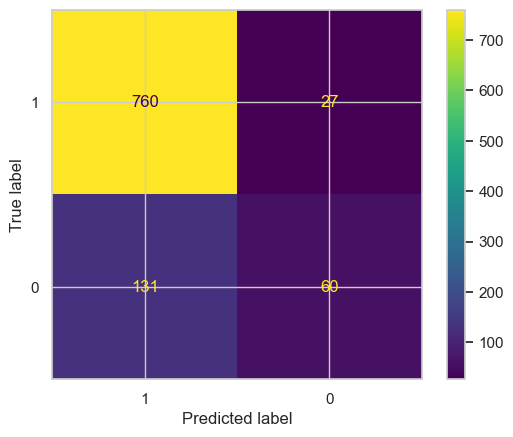


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       787
           1       0.69      0.31      0.43       191

    accuracy                           0.84       978
   macro avg       0.77      0.64      0.67       978
weighted avg       0.82      0.84      0.81       978



In [113]:
model_log_1_base = LogisticRegression() # instantiated the model
model_log_1_base.fit(X_train_scaled, y_train) #fitted the model

# applied model evaluation function to verify the testing and training accuracy, and obtained the confusion matrix to calculate 
# the precision, recall and f1-score of each classes. 
model_evaluation(model_log_1_base, 
                 y_train,
                 y_test,
                 X_train_scaled,
                 X_test_scaled)


The Training accuracy of the model is 85.1% and the testing accuracy of the model is 83.5%. 

AUC =0.8003286388099815


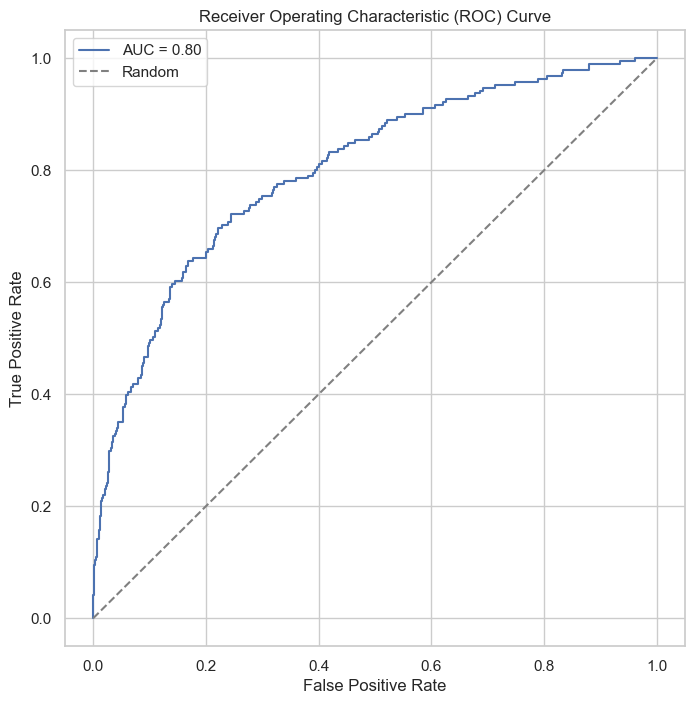

In [114]:
auc_roc_curve(model_log_1_base,X_test_scaled,y_test) 

Model is 80% confident in it's classification of the target values

#### 2) Model Tuning 1 - Class Imbalance

#### Over Sampling

In [115]:
ros = RandomOverSampler(random_state=100)      # initializing the randome over sampler object
X_log_ros, y_log_ros = ros.fit_resample(X_enc,y)       # fitting tp encoded X data and y
print("Class distribution after oversampling is:", Counter(y_log_ros))      

Class distribution after oversampling is: Counter({1: 3968, 0: 3968})


Training Accuracy of this model: 0.740705734089477
Testing Accuracy of this model: 0.75

Confusion Matrix:


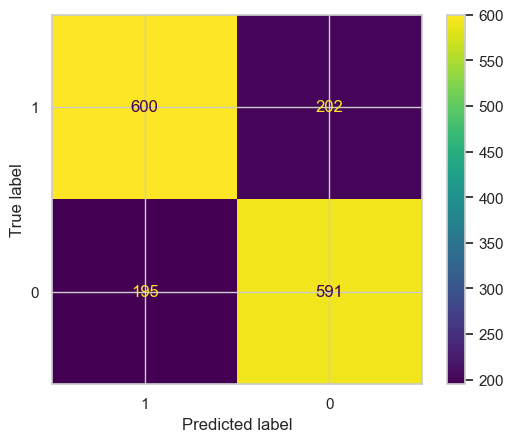


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       802
           1       0.75      0.75      0.75       786

    accuracy                           0.75      1588
   macro avg       0.75      0.75      0.75      1588
weighted avg       0.75      0.75      0.75      1588



In [116]:
# train test split
X_train_log_ros, X_test_log_ros, y_train_log_ros, y_test_log_ros = train_test_split(X_log_ros, y_log_ros, test_size=0.20, random_state=100)

# scaling data
scaler = StandardScaler()
X_train_log_ros_scaled = scaler.fit_transform(X_train_log_ros)
X_test_log_ros_scaled = scaler.transform(X_test_log_ros)


# logistic regression for over sampled data
model_log_2_ros = LogisticRegression()
model_log_2_ros.fit(X_train_log_ros_scaled, y_train_log_ros)


# evaluating the data
model_evaluation(model_log_2_ros,
                 y_train_log_ros,
                 y_test_log_ros,
                 X_train_log_ros_scaled,
                 X_test_log_ros_scaled)




AUC =0.8183041124923061


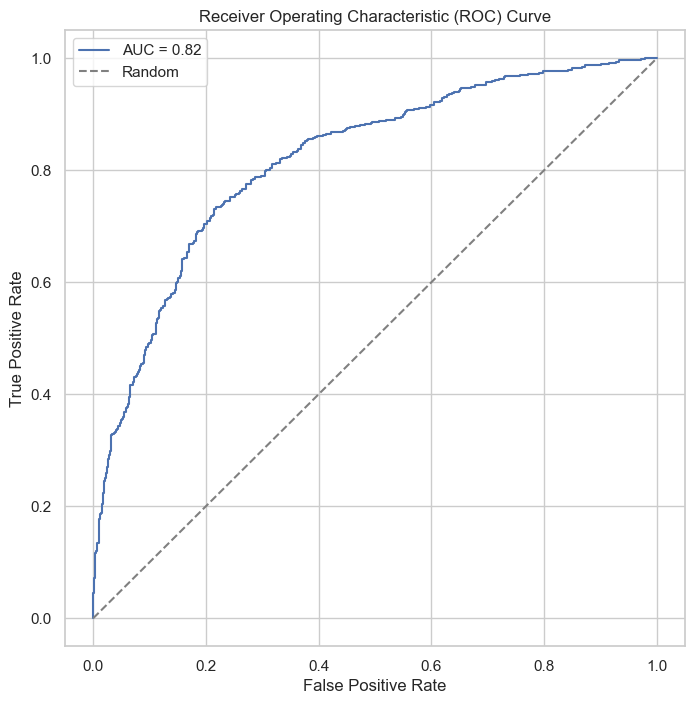

In [117]:
auc_roc_curve(model_log_2_ros,X_test_log_ros_scaled,y_test_log_ros)

After doing over sampling the AUC score has slightly increased. The model is performing better

#### UnderSampling

In [118]:

rus = RandomUnderSampler(random_state=42)    # initiating the object
X_log_rus, y_log_rus = rus.fit_resample(X_enc, y)     # fitting encoded data and resampled data
print("Class distribution after oversampling:", Counter(y_log_rus))

Class distribution after oversampling: Counter({0: 920, 1: 920})


Training Accuracy of this model: 0.748641304347826
Testing Accuracy of this model: 0.7663043478260869

Confusion Matrix:


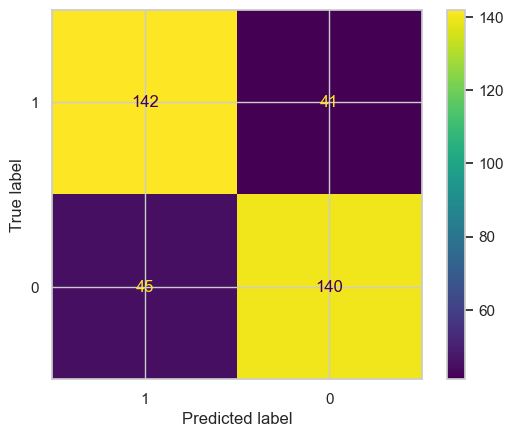


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       183
           1       0.77      0.76      0.77       185

    accuracy                           0.77       368
   macro avg       0.77      0.77      0.77       368
weighted avg       0.77      0.77      0.77       368



In [119]:
# train test split
X_train_log_rus, X_test_log_rus, y_train_log_rus, y_test_log_rus = train_test_split(X_log_rus, y_log_rus, test_size= 0.20, random_state= 100)

# scaling
scaler = StandardScaler()
X_train_log_rus_scaled = scaler.fit_transform(X_train_log_rus)
X_test_log_rus_scaled = scaler.transform(X_test_log_rus)

# Logistic Regression for under sampled data
model_log_2_rus = LogisticRegression()
model_log_2_rus.fit(X_train_log_rus_scaled,y_train_log_rus)

# model evaluation
model_evaluation(model_log_2_rus,
                 y_train_log_rus,
                 y_test_log_rus,
                 X_train_log_rus_scaled,
                 X_test_log_rus_scaled)

AUC =0.5


c:\Users\ArshiaAchar\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


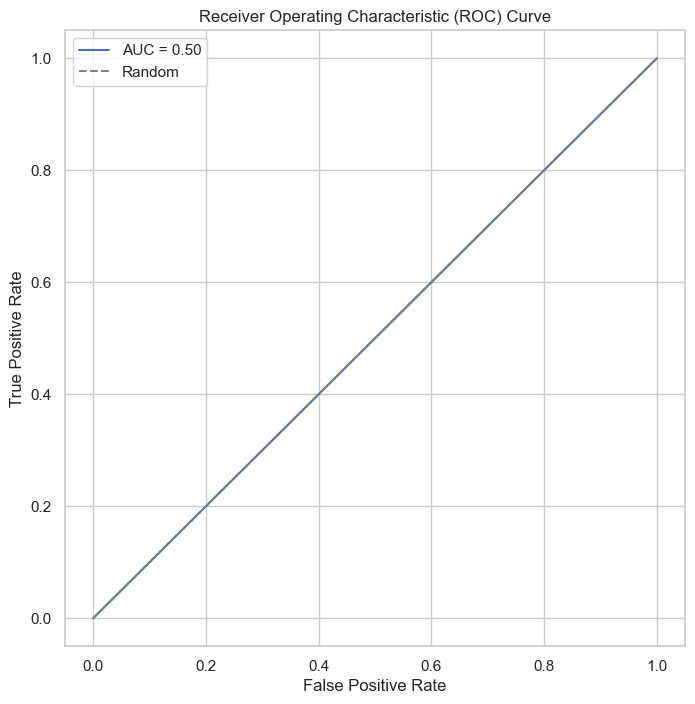

In [120]:
auc_roc_curve(model_log_2_rus,X_test_log_rus,y_test_log_rus)

This model is a random value generator with an AUC score of 0.5. That means the values are randomly predicted from the model. The confidence the model has in the data is 50%. WIth under sampling the model is less precise and confident in it's predictions

### SMOTE

In [121]:

# creating synthetic data using SMOTE
smote = SMOTE(random_state=100)
X_log_smt, y_log_smt = smote.fit_resample(X_enc, y)     # fitting encoded data and resampled data
print("Class distribution after oversampling:", Counter(y_log_smt))

Class distribution after oversampling: Counter({1: 3968, 0: 3968})


Training Accuracy of this model: 0.8954001260239446
Testing Accuracy of this model: 0.8998740554156172

Confusion Matrix:


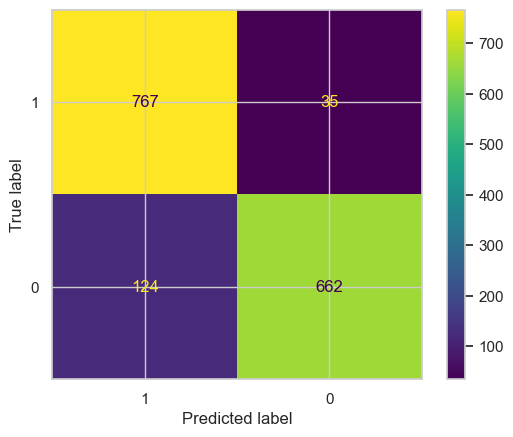


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       802
           1       0.95      0.84      0.89       786

    accuracy                           0.90      1588
   macro avg       0.91      0.90      0.90      1588
weighted avg       0.90      0.90      0.90      1588



In [122]:
# train test split
X_train_log_smt, X_test_log_smt, y_train_log_smt, y_test_log_smt = train_test_split(X_log_smt, y_log_smt, test_size=0.2, random_state=100)

# scaling the data
scaler = StandardScaler()
X_train_log_smt_scaled = scaler.fit_transform(X_train_log_smt)
X_test_log_smt_scaled = scaler.transform(X_test_log_smt)

# Logistic regression for smote data
model_log_2_smt = LogisticRegression()
model_log_2_smt.fit(X_train_log_smt_scaled, y_train_log_smt)

# Model evaluation
model_evaluation(model_log_2_smt,
                 y_train_log_smt,
                 y_test_log_smt,
                 X_train_log_smt_scaled,
                 X_test_log_smt_scaled
                 )


AUC =0.9554961197515119


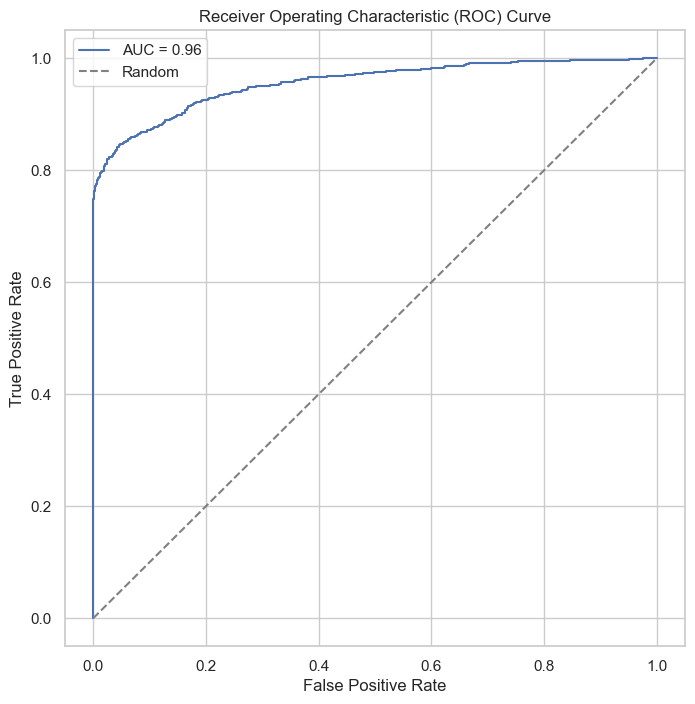

In [123]:
auc_roc_curve(model_log_2_smt,X_test_log_smt_scaled,y_test_log_smt)

This model gives a very good AUC score. It  tells us that the model is fitting and confident to the data 96% of the times. 

#### 3) Model Tuning 2 - Regularization

#### Ridge Regularization

In [124]:
# Splitting dataset intro train and test 
X_train_log_reg, X_test_log_reg, y_train_log_reg, y_test_log_reg = train_test_split(X_log_smt, y_log_smt, test_size=0.2, random_state=42)

# Scaling dataset
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_log_reg)
X_test_reg_scaled = scaler.transform(X_test_log_reg)

In [125]:
# Train logistic regression with ridge regularization
model_log_3_rdg = LogisticRegression(penalty='l2',solver='liblinear',C=0.9)       # using lib linear solver as it performs best with L2
model_log_3_rdg.fit(X_train_reg_scaled, y_train_log_reg)

LogisticRegression(C=0.9, solver='liblinear')

Training Accuracy of this model: 0.8947700063011972
Testing Accuracy of this model: 0.8879093198992444

Confusion Matrix:


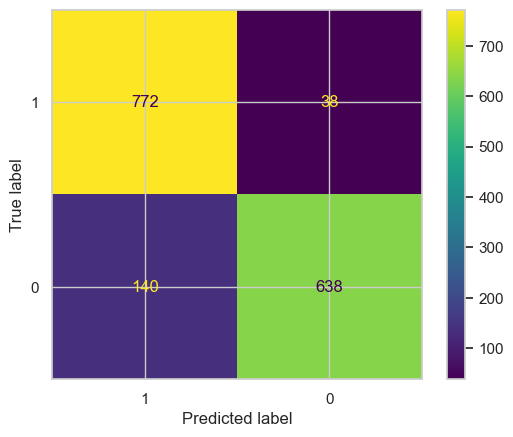


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       810
           1       0.94      0.82      0.88       778

    accuracy                           0.89      1588
   macro avg       0.90      0.89      0.89      1588
weighted avg       0.89      0.89      0.89      1588



In [126]:
model_evaluation(model_log_3_rdg,
                 y_train_log_reg,
                 y_test_log_reg,
                 X_train_reg_scaled,
                 X_test_reg_scaled)

AUC =0.9443777968199563


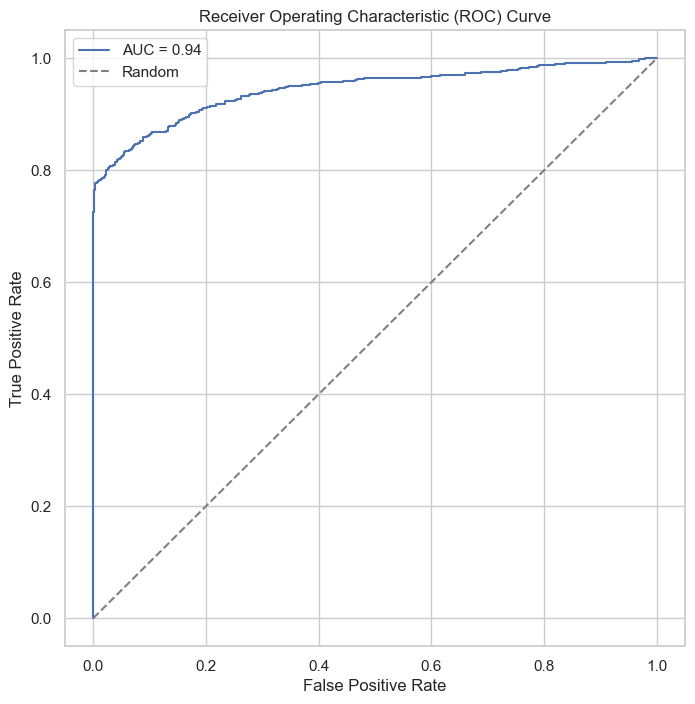

In [127]:
auc_roc_curve(model_log_3_rdg,X_test_reg_scaled,y_test_log_reg)

Ridge Regularization of logistic regression has improved vastly from the base model with it being more confident in it's target category classification. Two reasons for this are that we are now using the smote dataset and the regularization we are doing using L2 as our penalty. 

#### Lasso Regularization

In [128]:
# Evaluate the model
# Train logistic regression with ridge regularization
model_log_3_las = LogisticRegression(penalty='l1',solver='liblinear',C=0.5)
model_log_3_las.fit(X_train_reg_scaled, y_train_log_reg)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

Training Accuracy of this model: 0.894927536231884
Testing Accuracy of this model: 0.8879093198992444

Confusion Matrix:


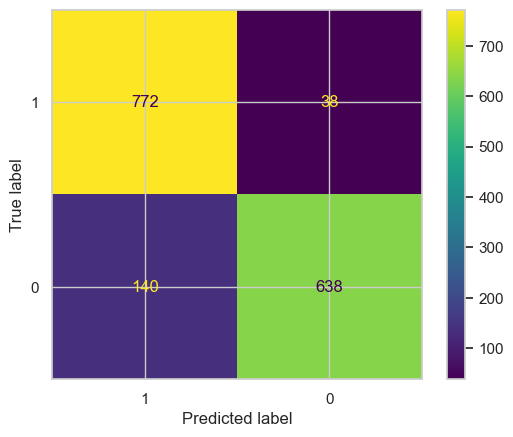


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       810
           1       0.94      0.82      0.88       778

    accuracy                           0.89      1588
   macro avg       0.90      0.89      0.89      1588
weighted avg       0.89      0.89      0.89      1588



In [129]:
model_evaluation(model_log_3_las,
                 y_train_log_reg,
                 y_test_log_reg,
                 X_train_reg_scaled,
                 X_test_reg_scaled)

AUC =0.9444730077120822


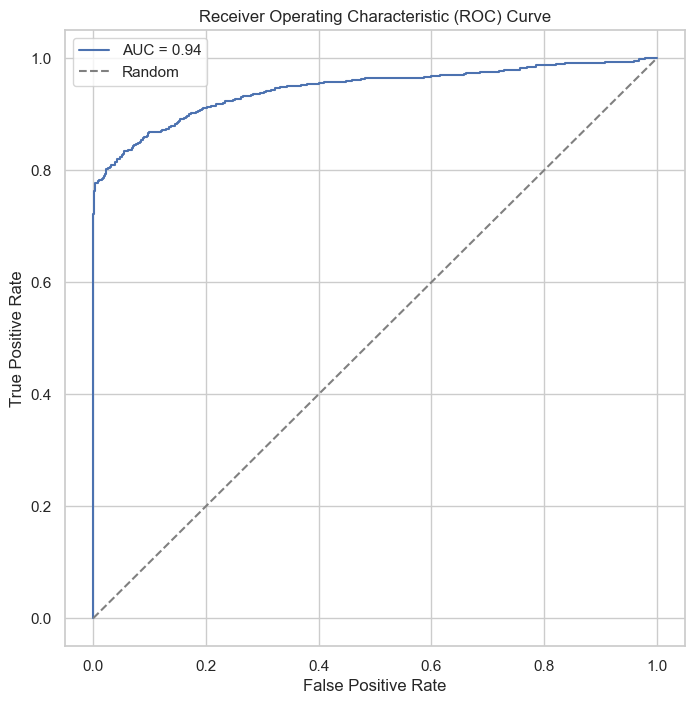

In [130]:
auc_roc_curve(model_log_3_las,X_test_reg_scaled,y_test_log_reg)

Lasso and ridge are performing very similar in terms of Training acc, testing acc and the AUC score

#### ElasticNet Regularization

In [131]:
model_log_3_en = LogisticRegression(penalty='elasticnet',solver='saga',C=0.9,l1_ratio=0.25,max_iter=5000)
model_log_3_en.fit(X_train_reg_scaled, y_train_log_reg)

LogisticRegression(C=0.9, l1_ratio=0.25, max_iter=5000, penalty='elasticnet',
                   solver='saga')

Training Accuracy of this model: 0.8950850661625709
Testing Accuracy of this model: 0.8879093198992444

Confusion Matrix:


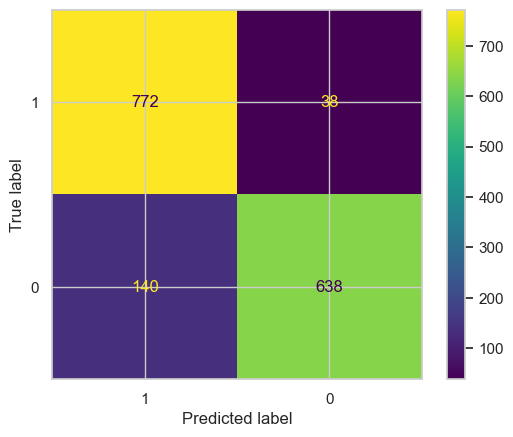


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       810
           1       0.94      0.82      0.88       778

    accuracy                           0.89      1588
   macro avg       0.90      0.89      0.89      1588
weighted avg       0.89      0.89      0.89      1588



In [132]:
model_evaluation(model_log_3_en,
                 y_train_log_reg,
                 y_test_log_reg,
                 X_train_reg_scaled,
                 X_test_reg_scaled)

AUC =0.9444111206322005


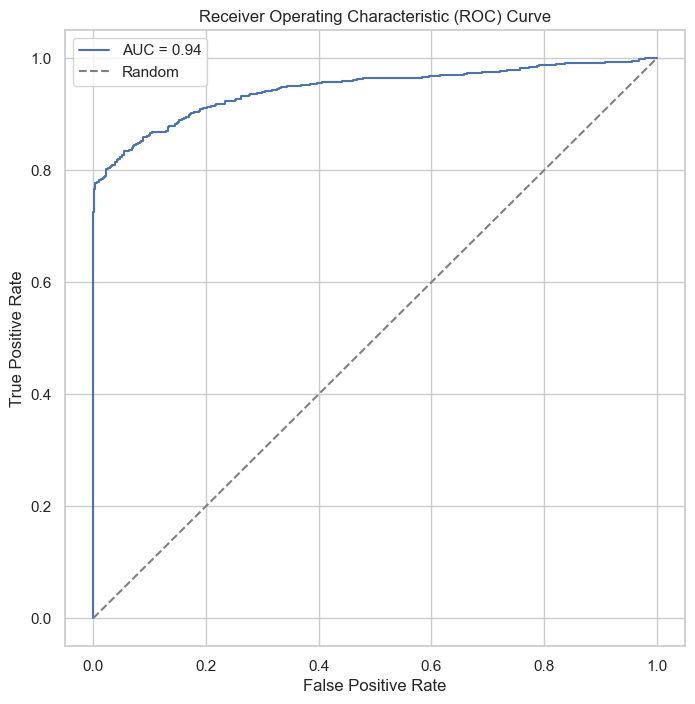

In [133]:
auc_roc_curve(model_log_3_en,X_test_reg_scaled,y_test_log_reg)

This model performs the exact same as the previous 2 regularization. No point moving forward with this one.

##### 4) Model Tuning 3 - Grid Search

In [134]:

from sklearn.model_selection import GridSearchCV
param_grid_log ={'C': [0.95,0.99,1.0,2.0,3.0,2.5,3.5,4.0,5.0],
              'penalty':['l2','l1'],
              'solver':['liblinear']
              }
grid_search = GridSearchCV(model_log_3_rdg, param_grid_log, cv = 2,scoring='accuracy',verbose=1,return_train_score=True)
grid_search.fit(X_train_reg_scaled, y_train_log_reg) #Fit the GridSearchCV object to the training data
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_ # Get the Best Parameter
training_accuracy = best_model.score(X_train_reg_scaled, y_train_log_reg) #Evaluate on Test Set
print(training_accuracy)
test_accuracy = best_model.score(X_test_reg_scaled, y_test_log_reg) #Evaluate on Test Set
print(test_accuracy)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


0.8955576559546313
0.8897984886649875


Tuning this model to find optimal parameters

In [135]:
best_params

{'C': 3.0, 'penalty': 'l1', 'solver': 'liblinear'}

Using these parameters, passing another Logistics regression model to view if there is an increase in the performance of the model

In [136]:
model_log_4_grid = LogisticRegression(penalty='l2',solver='liblinear',C=2.5)
model_log_4_grid.fit(X_train_reg_scaled, y_train_log_reg)

LogisticRegression(C=2.5, solver='liblinear')

Training Accuracy of this model: 0.8954001260239446
Testing Accuracy of this model: 0.889168765743073

Confusion Matrix:


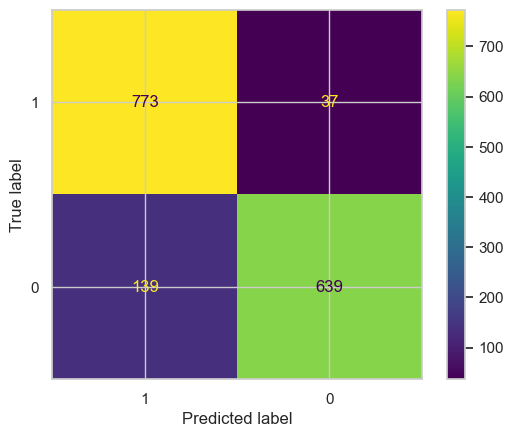


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       810
           1       0.95      0.82      0.88       778

    accuracy                           0.89      1588
   macro avg       0.90      0.89      0.89      1588
weighted avg       0.90      0.89      0.89      1588



In [137]:
model_evaluation(model_log_4_grid,
                 y_train_log_reg,
                 y_test_log_reg,
                 X_train_reg_scaled,
                 X_test_reg_scaled)

AUC =0.9443984258465836


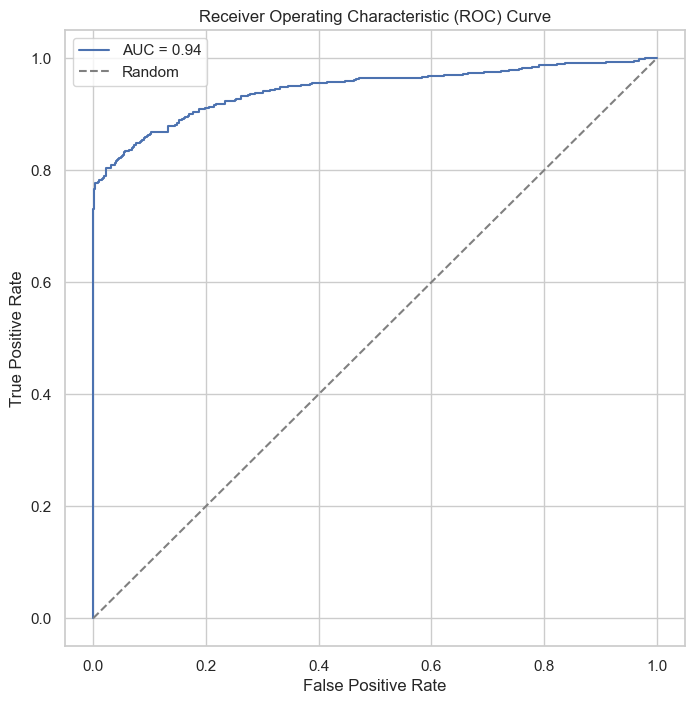

In [138]:
auc_roc_curve(model_log_4_grid,X_test_reg_scaled,y_test_log_reg)

##### After grid search the received optimal parameters are improving the model slightly. Not that significant change. Large value of c implies that lambda is small. This would mean that the importance or coefficient of the regularized term is less. That is why regularization models are not affecting the accuracy of the base logistic regression model. There is no need to perform regularization. The tuning for class imbalance and the above model using grid search optimal hyperparameters are sufficient for this modelling.

### Support Vector Machine

##### 1) Base Modelling

Training Accuracy of this model: 0.8450127877237852
Testing Accuracy of this model: 0.8353783231083844

Confusion Matrix:


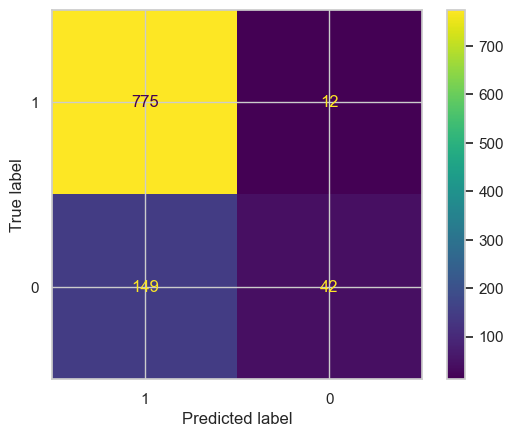


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       787
           1       0.78      0.22      0.34       191

    accuracy                           0.84       978
   macro avg       0.81      0.60      0.62       978
weighted avg       0.83      0.84      0.80       978



In [139]:
model_svm_1_base = svm.SVC(kernel = 'linear',probability=True)
model_svm_1_base.fit(X_train_scaled,y_train)
model_evaluation(model_svm_1_base,
                 y_train,
                 y_test,
                 X_train_scaled,
                 X_test_scaled)


AUC =0.7902565910708703


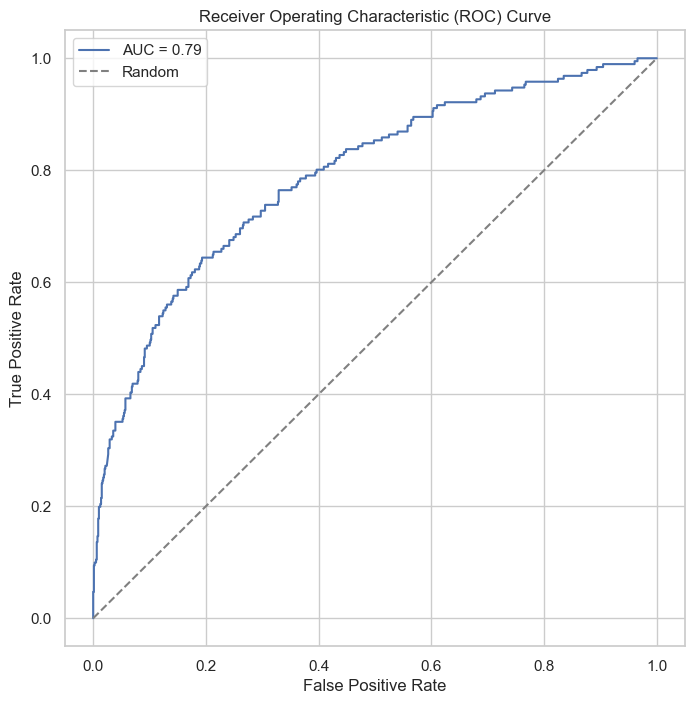

In [140]:
auc_roc_curve(model_svm_1_base,X_test_scaled,y_test)

- There is slight overfitting in the data
- Class imbalancing results in varying precision for both target classes with 0 class having more data points compared to 1
- class 0 has all its metrics as higher as it has more data points
- linear kernel chosen could be a factor for lower performance of model
- as the number of features have a degree of more than 1, linear kernel chosen would not be able to provide the best results.

#### 2) Model Tuning 1 - Class Imbalance

##### OverSampling

In [141]:
ros = RandomOverSampler(random_state=42)    # initiating the object
X_svm_ros, y_svm_ros = ros.fit_resample(X_enc, y)     # fitting encoded data and resampled data
print("Class distribution after oversampling:", Counter(y_svm_ros))

Class distribution after oversampling: Counter({1: 3968, 0: 3968})


Training Accuracy of this model: 0.745274102079395
Testing Accuracy of this model: 0.7449622166246851

Confusion Matrix:


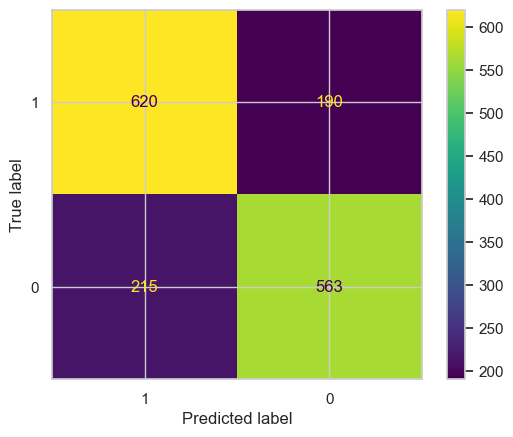


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       810
           1       0.75      0.72      0.74       778

    accuracy                           0.74      1588
   macro avg       0.75      0.74      0.74      1588
weighted avg       0.75      0.74      0.74      1588



In [142]:
X_train_svm_ros, X_test_svm_ros, y_train_svm_ros, y_test_svm_ros = train_test_split(X_svm_ros, y_svm_ros, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_svm_ros_scaled = scaler.fit_transform(X_train_svm_ros)
X_test_svm_ros_scaled = scaler.transform(X_test_svm_ros)

model_svm_2_ros = svm.SVC(kernel = 'linear',probability=True)
model_svm_2_ros.fit(X_train_svm_ros_scaled, y_train_svm_ros)
model_evaluation(model_svm_2_ros,
                 y_train_svm_ros,
                 y_test_svm_ros,
                 X_train_svm_ros_scaled,
                 X_test_svm_ros_scaled)



AUC =0.7975419721349456


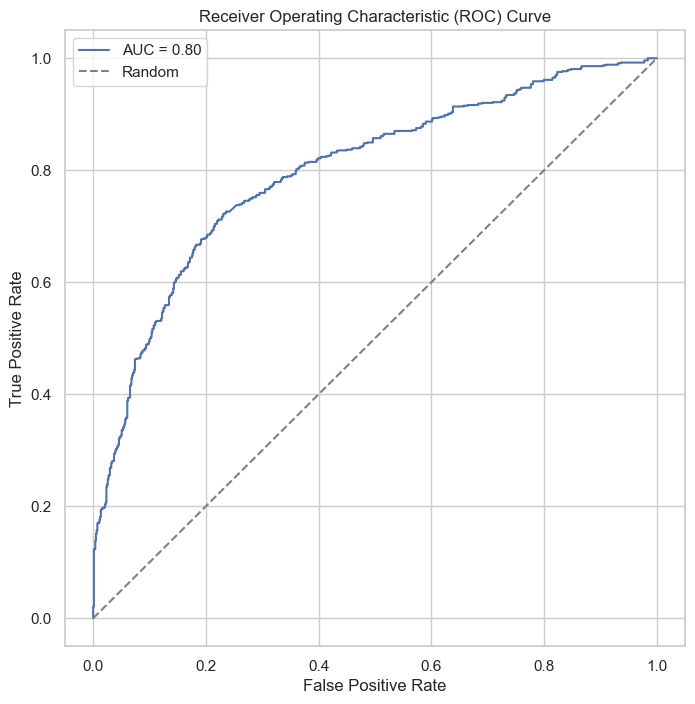

In [143]:
auc_roc_curve(model_svm_2_ros,X_test_svm_ros_scaled,y_test_svm_ros)

<li> No overfitting as compared to previous model
<li> Model is underfitting due to oversampling our target class
<li> Not a great change in the AUC score for both models

##### UnderSampling

In [144]:
rus = RandomUnderSampler(random_state=42)    # initiating the object
X_svm_rus, y_svm_rus = rus.fit_resample(X_enc, y)     # fitting encoded data and resampled data
print("Class distribution after oversampling:", Counter(y_svm_rus))

Class distribution after oversampling: Counter({0: 920, 1: 920})


Training Accuracy of this model: 0.7601902173913043
Testing Accuracy of this model: 0.7065217391304348

Confusion Matrix:


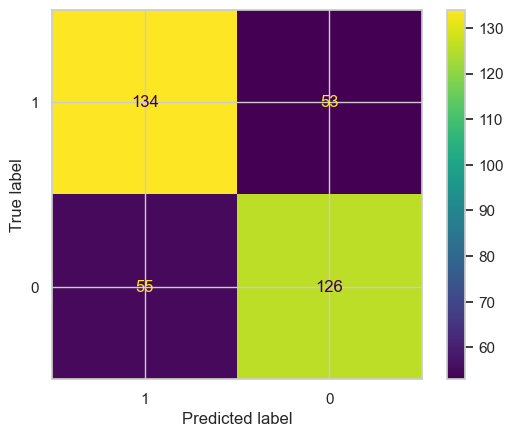


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       187
           1       0.70      0.70      0.70       181

    accuracy                           0.71       368
   macro avg       0.71      0.71      0.71       368
weighted avg       0.71      0.71      0.71       368



In [145]:
X_train_svm_rus, X_test_svm_rus, y_train_svm_rus, y_test_svm_rus = train_test_split(X_svm_rus, y_svm_rus, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_svm_rus_scaled = scaler.fit_transform(X_train_svm_rus)
X_test_svm_rus_scaled = scaler.transform(X_test_svm_rus)

model_svm_2_rus = svm.SVC(kernel = 'linear',probability=True)
model_svm_2_rus.fit(X_train_svm_rus_scaled, y_train_svm_rus)
model_evaluation(model_svm_2_rus,
                 y_train_svm_rus,
                 y_test_svm_rus,
                 X_train_svm_rus_scaled,
                 X_test_svm_rus_scaled
                 )



AUC =0.7604218985434454


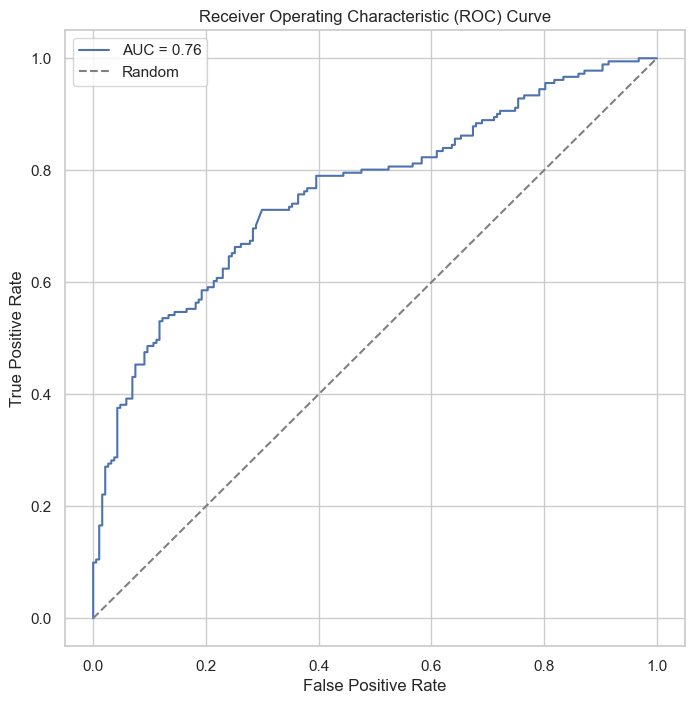

In [146]:
auc_roc_curve(model_svm_2_rus,X_test_svm_rus_scaled,y_test_svm_rus)

With undersampling the model is performing better but it is overfitting and has a lower AUC score. Not a good step for our model

##### SMOTE

In [147]:
smote = SMOTE(random_state=100)

X_svm_smt, y_svm_smt = smote.fit_resample(X_enc, y)     # fitting encoded data and resampled data
print("Class distribution after oversampling:", Counter(y_svm_smt))


Class distribution after oversampling: Counter({1: 3968, 0: 3968})


Training Accuracy of this model: 0.8955576559546313
Testing Accuracy of this model: 0.9005037783375315

Confusion Matrix:


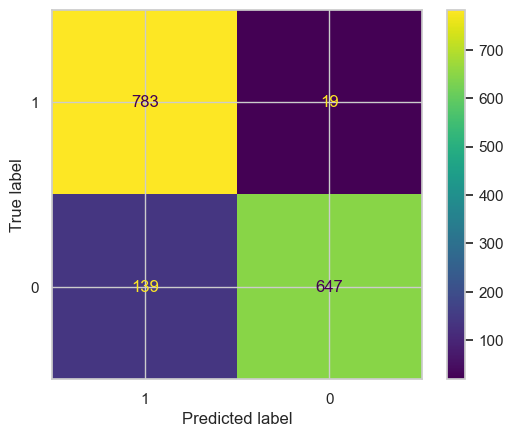


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       802
           1       0.97      0.82      0.89       786

    accuracy                           0.90      1588
   macro avg       0.91      0.90      0.90      1588
weighted avg       0.91      0.90      0.90      1588



In [148]:
X_train_svm_smt, X_test_svm_smt, y_train_svm_smt, y_test_svm_smt = train_test_split(X_svm_smt, y_svm_smt, test_size=0.2, random_state=100)

scaler = StandardScaler()
X_train_svm_smt_scaled = scaler.fit_transform(X_train_svm_smt)
X_test_svm_smt_scaled = scaler.transform(X_test_svm_smt)

model_svm_2_smt = svm.SVC(kernel = 'linear',probability=True)
model_svm_2_smt.fit(X_train_svm_smt_scaled, y_train_svm_smt)
model_evaluation(model_svm_2_smt,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )



AUC =0.9558149790917109


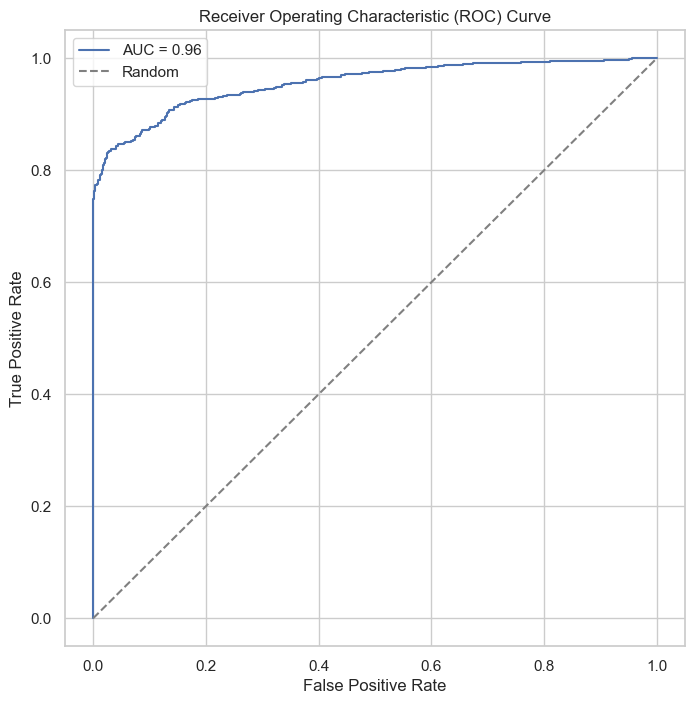

In [149]:
auc_roc_curve(model_svm_2_smt,X_test_svm_smt_scaled,y_test_svm_smt)

In this tuning of the model, we balanced the number of records for the target variable. The number of records have been synthetically created in SMOTE analysis to balance the imbalanced data. This method of taking care of Imbalanced data that we have used is the best technique. As we can see that there is no overfitting and all the metrics for both target classes are similar and more efficient. The AUC score for this technique is also the highest.

Moving forward we will use this balancing technique for the rest of the models.

#### 3) Model Tuning 2 - Kernel Selection

There are various kernels used in SVM. We will try modelling with a different kernel to compare results

In [150]:
X_train_svm_smt, X_test_svm_smt, y_train_svm_smt, y_test_svm_smt = train_test_split(X_svm_smt, y_svm_smt, test_size=0.2, random_state=100)

scaler = StandardScaler()
X_train_svm_smt_scaled = scaler.fit_transform(X_train_svm_smt)
X_test_svm_smt_scaled = scaler.transform(X_test_svm_smt)

Different kernels taken by SVC : {'linear', 'rbf', 'poly', 'precomputed', 'sigmoid'}

Training Accuracy of this model: 0.8955576559546313
Testing Accuracy of this model: 0.9005037783375315

Confusion Matrix:


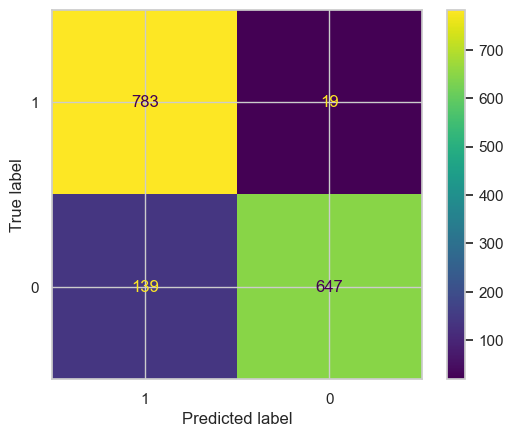


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       802
           1       0.97      0.82      0.89       786

    accuracy                           0.90      1588
   macro avg       0.91      0.90      0.90      1588
weighted avg       0.91      0.90      0.90      1588



In [151]:
model_svm_3_lin = svm.SVC(kernel = 'linear',probability=True)
model_svm_3_lin.fit(X_train_svm_smt_scaled,y_train_svm_smt)
model_evaluation(model_svm_3_lin,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )


AUC =0.9558133927268343


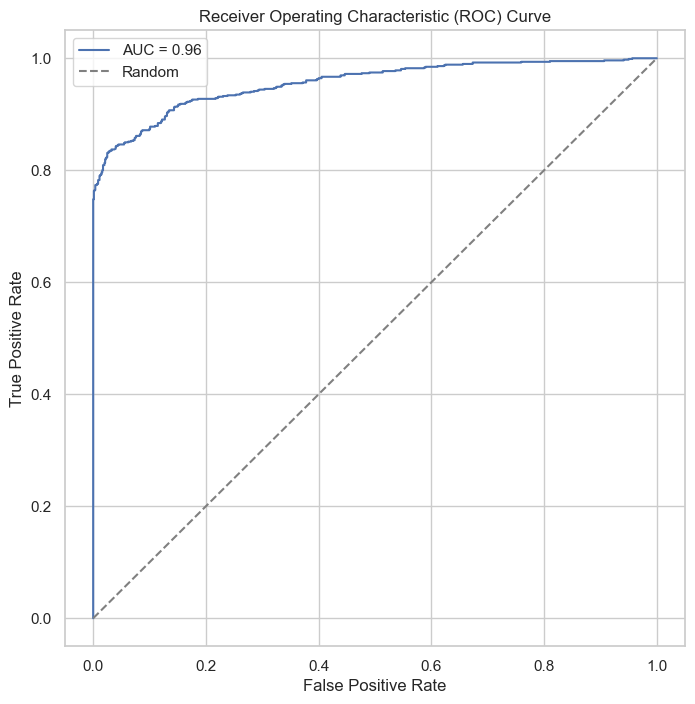

In [152]:
auc_roc_curve(model_svm_3_lin,X_test_svm_smt_scaled,y_test_svm_smt)

#### Polynomial

Training Accuracy of this model: 0.9678638941398866
Testing Accuracy of this model: 0.9414357682619647

Confusion Matrix:


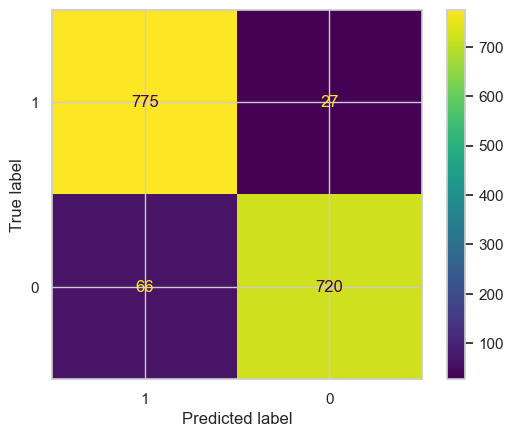


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       802
           1       0.96      0.92      0.94       786

    accuracy                           0.94      1588
   macro avg       0.94      0.94      0.94      1588
weighted avg       0.94      0.94      0.94      1588



In [153]:
model_svm_3_poly = svm.SVC(kernel = 'poly',probability=True)
model_svm_3_poly.fit(X_train_svm_smt_scaled,y_train_svm_smt)
model_evaluation(model_svm_3_poly,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )


AUC =0.9815410582957365


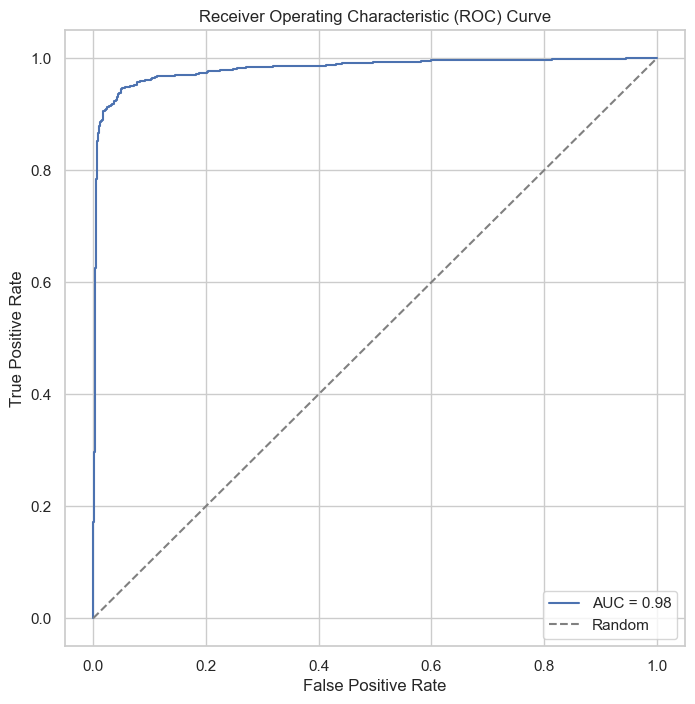

In [154]:
auc_roc_curve(model_svm_3_poly,X_test_svm_smt_scaled,y_test_svm_smt)

The polynomial kernel is a much better option for our SVM model than the linear model. Which makes sense as we have a large number of features. So, having more dimensions would make the class margin maximization more easier. 

#### RBF

Training Accuracy of this model: 0.9524259609325771
Testing Accuracy of this model: 0.9351385390428212

Confusion Matrix:


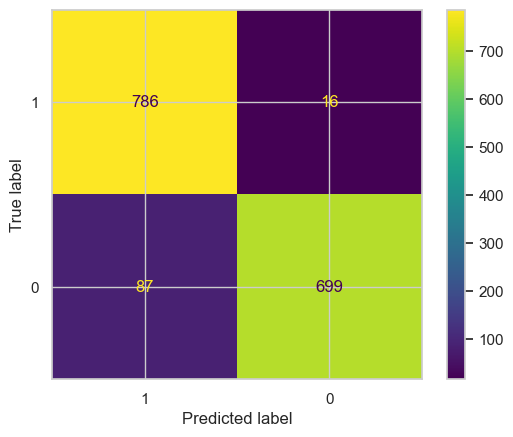


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       802
           1       0.98      0.89      0.93       786

    accuracy                           0.94      1588
   macro avg       0.94      0.93      0.93      1588
weighted avg       0.94      0.94      0.93      1588



In [155]:
model_svm_3_rbf = svm.SVC(kernel = 'rbf',gamma='scale',probability=True)
model_svm_3_rbf.fit(X_train_svm_smt_scaled,y_train_svm_smt)
model_evaluation(model_svm_3_rbf,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )


AUC =0.9824865317621976


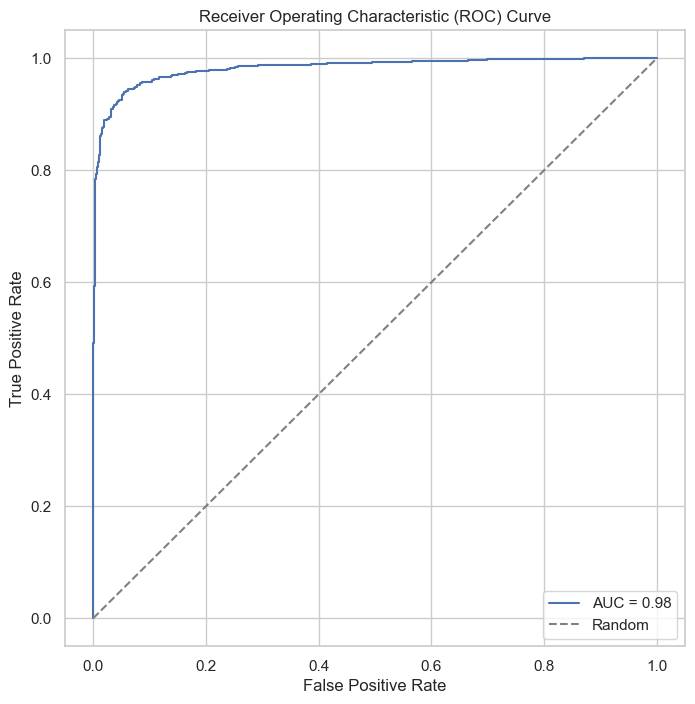

In [156]:
auc_roc_curve(model_svm_3_rbf,X_test_svm_smt_scaled,y_test_svm_smt)

#### Sigmoid

Training Accuracy of this model: 0.7988342785129174
Testing Accuracy of this model: 0.8123425692695214

Confusion Matrix:


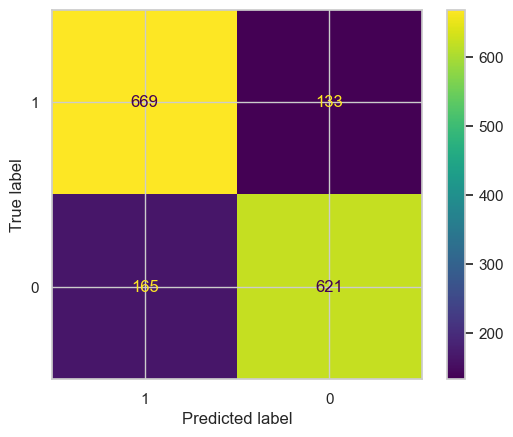


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       802
           1       0.82      0.79      0.81       786

    accuracy                           0.81      1588
   macro avg       0.81      0.81      0.81      1588
weighted avg       0.81      0.81      0.81      1588



In [157]:
model_svm_3_sig = svm.SVC(kernel = 'sigmoid',probability=True)
model_svm_3_sig.fit(X_train_svm_smt_scaled,y_train_svm_smt)
model_evaluation(model_svm_3_sig,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )


AUC =0.867828837575273


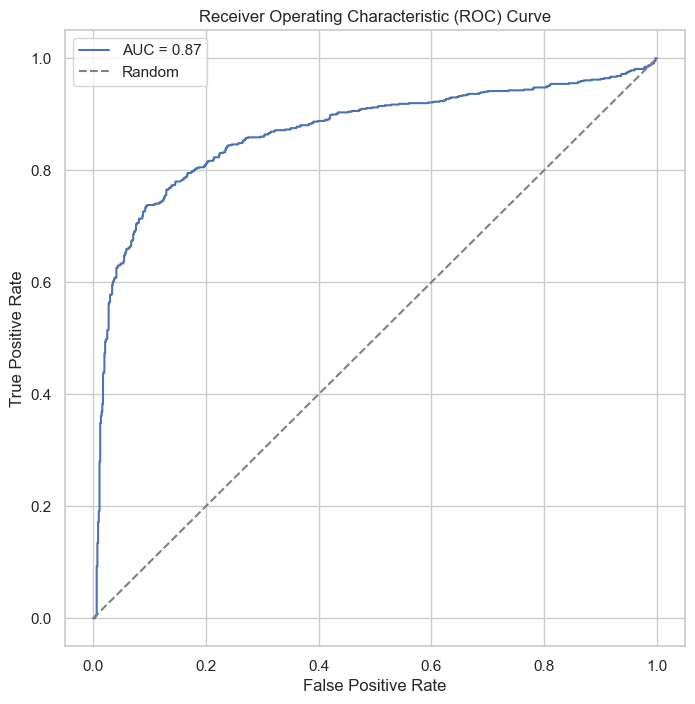

In [158]:
auc_roc_curve(model_svm_3_sig,X_test_svm_smt_scaled,y_test_svm_smt)

RBF and sigmoid kernels performed better than the linear kernel but not as efficiently as the Polynomial kernel. 

We will be moving forward with the polynomial kernel to grid seach other optimal hypermarameters that would improve our model further

#### 4) Model Tuning 3 - Regularization using GridSearchCV

In [159]:

from sklearn.model_selection import GridSearchCV
# max_iter_values = np.arange(50,501,50)
param_grid = {'C': [0.7,0.9,1.0,0.95,0.97,1.5],
              'kernel':['poly'],
              'degree':[2,3,4,5]}

grid_search = GridSearchCV(model_svm_3_poly, param_grid, cv = 2,scoring='accuracy',verbose=1,return_train_score=True)
grid_search.fit(X_train_svm_smt_scaled, y_train_svm_smt) #Fit the GridSearchCV object to the training data
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_ # Get the Best Parameter
test_accuracy = best_model.score(X_test_svm_smt_scaled, y_test_svm_smt) #Evaluate on Test Set
print(test_accuracy)

training_accuracy = best_model.score(X_train_svm_smt_scaled, y_train_svm_smt) #Evaluate on Test Set
print(training_accuracy)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


0.9596977329974811
0.9867674858223062


In [160]:
best_params

{'C': 1.5, 'degree': 4, 'kernel': 'poly'}

Training Accuracy of this model: 0.9867674858223062
Testing Accuracy of this model: 0.9596977329974811

Confusion Matrix:


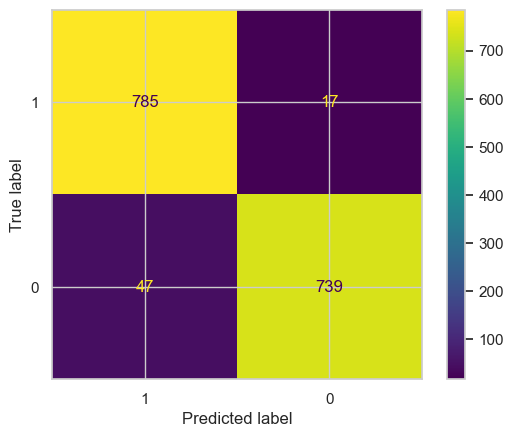


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       802
           1       0.98      0.94      0.96       786

    accuracy                           0.96      1588
   macro avg       0.96      0.96      0.96      1588
weighted avg       0.96      0.96      0.96      1588



In [161]:
model_svm_4_poly_reg = svm.SVC(kernel = 'poly',degree=4,C=1.5,probability=True)
model_svm_4_poly_reg.fit(X_train_svm_smt_scaled,y_train_svm_smt)
model_evaluation(model_svm_4_poly_reg,
                 y_train_svm_smt,
                 y_test_svm_smt,
                 X_train_svm_smt_scaled,
                 X_test_svm_smt_scaled
                 )


AUC =0.9920586574276775


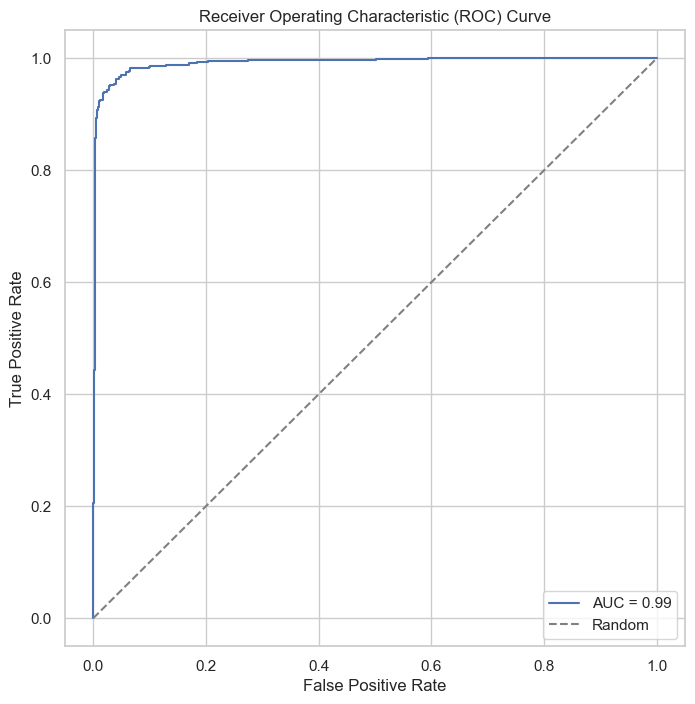

In [162]:
auc_roc_curve(model_svm_4_poly_reg,X_test_svm_smt_scaled,y_test_svm_smt)

Doing grid search for SVM model using provided hyperparameters gives optimal kernel, C and and polynomial degree value. Using these in the model we can see that there is an increase in the model accuracy for training as well as testing. 99% training accuracy and 95% testing accuracy makes the model slightly overfitted but over all the model is performing great witha good AUC score. 0.98 AUC tells us that 98% confident the model is in its predictions. The polynomial solver that we have chosen has the optimal degree value of 4 telling us it is a highly complicated model. So, the chances of overfitting would be very high in this case. But, it is not. This is a good parameter list chosen and the model is good.

### Comparision of both Models

<li> In Logistic Regression, the base model had a reduced accuracy as compared to the base model of SVM. This tells us that without any optimization alogrithms SVM performs better than Logistic. 

<li> Even after tuning the Logistic model there was an improvement in the performance. This was due to mainly the class imbalancing technique we incorporated and the the optimal hyperparameters we got. The AUC, training accuracy and testing accuracy for this model was lower than what we obtained for SVM. 

<li> The SVM model after all the tuning has a much better accuracy than the logistic regession model. The AUC score, training accuracy and testing accuracy are much higher than Logistic Regression.

#### Conclusion

Technical Conclusion:

In conclusion, SVM is a much better classification than Logistic regression. 

- This is because when we do margin maximization, the distinction between class is more stronger. 
- They are better at handling non linearity in variables using kernels. 
- They are robust to outliers.
- The risk of overfitting is less in Support Vector Machine models compared to Logistic Regression.
- Assumption of Logistic is the linearity in variables which is not necessary for SVM, leading to better performance for SVM

- The final model we chose is the SVM model. The equation followed by the SVM has degree 4 polynomial function. This means that it is a non linear with a high complexity. Non linearity in the model tells us about how the features are associated with the Target. 
- Even with such a complex equation that the model would overfit had it not been for an SVM proves that the SVM is robust to outliers.
- The lambda parameter which is the inverse of C, is low. This tells us that we are not regularizing the error term.
- The optimal parameters given by GridSearch tells us that, we need to chose a polynomial equation of degree 4 with low regularization. The model need not be regularized.

Business Conclusion:
This model was created to predict if an existing customer will accept the new plan (1) or Not (0). There were numerical as well as categorical attributes for each customer that was used in the modelling.

- The prediction depends on personal information of the customer, location of the customer, occupation, designation & salary of the customer, feedback provided by customer as well as the account they have currently with the Telecommunication company and the new plan being pitched to them.


<h1><center>END</center></h1>